In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload
from scipy.interpolate import interp1d

## Get the spectra for a given day

In [2]:
#Defining the directory names used to extract the data.
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Solar-data/2023-01-21'
os.chdir(location)
dir_name = 'Corr-data'
blaze_dir = 'Blaze-data'
CCF_dir_name = 'CCF_RV-data'

#Creating a directory to store the results.
if not os.path.exists('Plot_Results'):
    os.mkdir('Plot_Results')

## Extract data

In [3]:
reload(AF)

#Extracting the data
tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)



## Remove outliers and low-SNR spectra

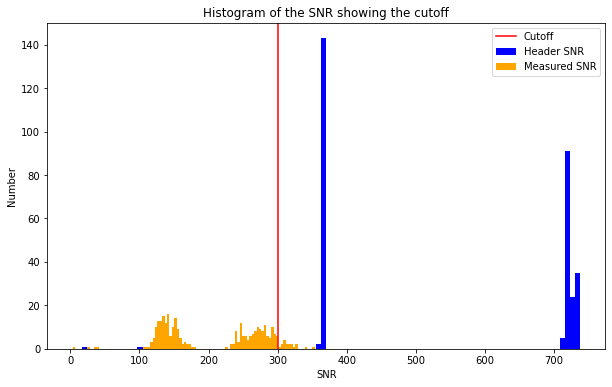

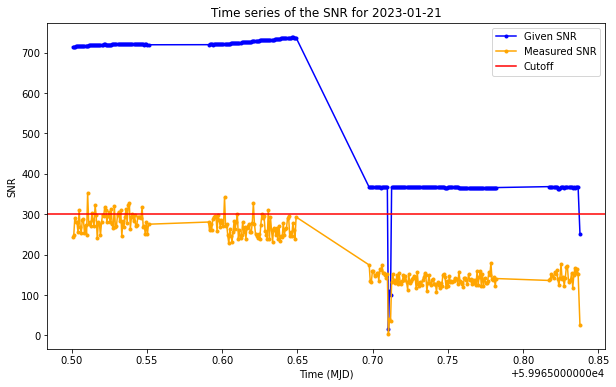

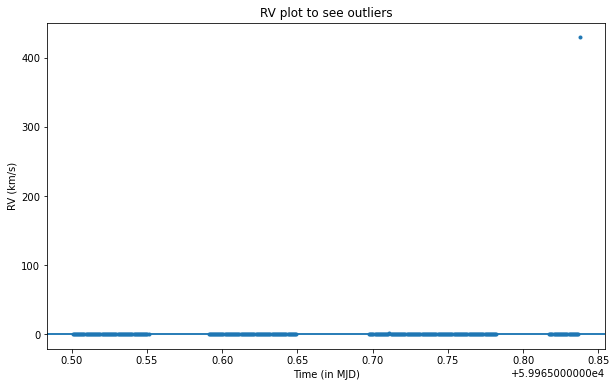

In [4]:
reload(AF)
#Defining a variable to save or not the results.
save = False
#Defining the thresholds and cuts for the RV and SNR clipping.
cut = 300
threshold = 0.2

#Defining the bounds on the piece of continuum we want to use to calculate the SNR.
low = 10767
up = 10770

#Calculating the continuum for a piece of spectral continuum.
measured_SNR = AF.SNR_calculator(low, up, tot_lamda, tot_spctr, tot_err)

#Making a histogram of the calculated SNR and the given SNR.
plt.figure(figsize=[10, 6])
plt.hist(tot_SNR, bins=100, color='blue', label='Header SNR')
plt.hist(measured_SNR, bins=100, color='orange', label='Measured SNR')
plt.axvline(cut, color='r', label='Cutoff')
plt.xlabel('SNR')
plt.ylabel('Number')
plt.title('Histogram of the SNR showing the cutoff')
plt.legend()
plt.show()

#Making a time series of the calculated SNR and the given SNR.
plt.figure(figsize=[10, 6])
plt.plot(tot_date[tot_SNR>0], tot_SNR[tot_SNR>0], 'b.', label='Given SNR', linestyle='-')
plt.plot(tot_date, measured_SNR, '.', color='orange', label='Measured SNR', linestyle='-')
plt.xlabel('Time (MJD)')
plt.ylabel('SNR')
plt.axhline(cut, color='r', label='Cutoff')
plt.title('Time series of the SNR for 2023-01-21')
plt.legend()
if save:
    plt.savefig('Plot_Results/SNR.pdf')
plt.show()

#Plotting the RV time series to see the cut and the possible outliers.
plt.figure(figsize=[10, 6])
plt.errorbar(tot_date, np.abs(tot_RV), yerr = np.abs(tot_RV_err), fmt='.')
plt.axhline((1+threshold)*np.median(np.abs(tot_RV)))
plt.axhline((1-threshold)*np.median(np.abs(tot_RV)))
plt.xlabel('Time (in MJD)')
plt.ylabel('RV (km/s)')
plt.title('RV plot to see outliers')
plt.show()


In [5]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    
    #Performing the data reduction by SNR and RV clipping.
    
    total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, cut, threshold)

    tota_norm_spctr_HA, tota_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, cut, threshold)

    total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, cut, threshold)
    
    total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, cut, threshold)

    tota_norm_err_HA, tota_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, cut, threshold)
    
    date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, cut, threshold)


#If there is one mode of observation
else:
    
    #Performing the data reduction by SNR and RV clipping.
    
    total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, cut, threshold)

    tota_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, cut, threshold)

    total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, cut, threshold)
    
    total_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, cut, threshold)

    tota_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, cut, threshold)
    
    date = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, cut, threshold)

    
mode = tot_mode

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


## Interpolation for ease

In [16]:
total_lamda_HA

array([[10737.85161125, 10737.89554857, 10737.93948376, ...,
        10888.18264482, 10888.21052908, 10888.2384084 ],
       [10737.85154964, 10737.89548696, 10737.93942215, ...,
        10888.18258235, 10888.21046661, 10888.23834593],
       [10737.85148901, 10737.89542633, 10737.93936152, ...,
        10888.18252087, 10888.21040513, 10888.23828445],
       ...,
       [10737.84102992, 10737.8849672 , 10737.92890234, ...,
        10888.17191535, 10888.19979958, 10888.22767887],
       [10737.84098872, 10737.884926  , 10737.92886114, ...,
        10888.17187357, 10888.19975781, 10888.2276371 ],
       [10737.84094772, 10737.88488499, 10737.92882013, ...,
        10888.17183199, 10888.19971623, 10888.22759552]])

In [27]:
print(min(total_lamda_HA[:,0]), max(total_lamda_HA[:,-1]))

10737.840947718198 10888.238408399566


In [28]:
print(min(total_lamda_HE[:,0]), max(total_lamda_HE[:,-1]))

10739.162509214299 10889.55993297956


In [21]:
np.where(total_lamda_HA[:, 0] == min(total_lamda_HA[:,0]))

(array([144]),)

In [33]:
np.mean(np.diff(total_lamda_HE))

0.036832940404545086

In [31]:
for i in range(len(total_lamda_HA)):
    print(np.mean(np.diff(total_lamda_HA[i])))

0.036832426437941906
0.03683242622661347
0.03683242601863656
0.036832425810631134
0.03683242560260121
0.036832425391137784
0.03683242518306954
0.036832424974988384
0.03683242476348665
0.03683242455539257
0.03683242434729804
0.03683242413579497
0.03683242392771247
0.036832423719642
0.03683242350817636
0.03683242330016692
0.03683242309215793
0.036832422884177006
0.036832422045805994
0.0368324218380554
0.03683242163033331
0.03683242141926372
0.03683242121166147
0.03683242100412471
0.03683242079325604
0.036832420585863626
0.03683242037857412
0.03683242017134165
0.03683241996079863
0.03683241975374391
0.03683241954678364
0.03683241933652931
0.036832419129771296
0.036832418923144254
0.036832418713216485
0.03683241850679215
0.03683241830048632
0.036832418094303446
0.036832417884868844
0.03683241767894615
0.03683241747315799
0.03683241726413771
0.03683241705863468
0.03683241685327821
0.03683241664471012
0.036832416439662834
0.03683241623477593
0.0368324160266961
0.03683241582214244
0.036832415

In [48]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):

    min_lamda = max(min(total_lamda_HA[:, 0]), min(total_lamda_HE[:, 0]))+1
    max_lamda = min(min(total_lamda_HA[:, -1]), min(total_lamda_HE[:, -1]))-1
    print(min_lamda, max_lamda)
    step = (np.mean(np.diff(total_lamda_HA))+np.mean(np.diff(total_lamda_HE)))/2
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda_HA[0]))
    
    total_norm_spctr_HA = np.zeros(tota_norm_spctr_HA.shape)
    total_norm_spctr_HE = np.zeros(tota_norm_spctr_HE.shape)
    
    total_norm_err_HA = np.zeros(tota_norm_err_HA.shape)
    total_norm_err_HE = np.zeros(tota_norm_err_HE.shape)
    
    for i in range(len(tota_norm_spctr_HA)):
        
        interpol_s = interp1d(total_lamda_HA[i], tota_norm_spctr_HA[i])
        print(total_lamda_HA[i], ref_wave)
        total_norm_spctr_HA[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HA[i], tota_norm_err_HA[i])
        total_norm_err_HA[i] = interpol_err(ref_wave)
        
    for i in range(len(tota_norm_spctr_HE)):
        
        interpol_s = interp1d(total_lamda_HE[i], tota_norm_spctr_HE[i])
        total_norm_spctr_HE[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HE[i], tota_norm_err_HE[i])
        total_norm_err_HE[i] = interpol_err(ref_wave)
        
else:
    
    ref_wave = total_lamda[0]
    
    total_norm_spctr = np.zeros(tota_norm_spctr.shape)

    total_norm_err = np.zeros(tota_norm_err.shape)
        
    for i in range(len(tota_norm_spctr)):
        
        interpol_s = interp1d(total_lamda[i], tota_norm_spctr[i])
        total_norm_spctr[i] = interpol_s(ref_wave, 'cubic')
        
        
        interpol_err = interp1d(total_lamda[i], tota_norm_err[i])
        total_norm_err[i] = interpol_err(ref_wave, 'cubic')

10740.162509214299 10887.22759551834
[10737.85161125 10737.89554857 10737.93948376 ... 10888.18264482
 10888.21052908 10888.2384084 ] [10740.16250921 10740.19852809 10740.23454697 ... 10887.15555776
 10887.19157664 10887.22759552]
[10737.85154964 10737.89548696 10737.93942215 ... 10888.18258235
 10888.21046661 10888.23834593] [10740.16250921 10740.19852809 10740.23454697 ... 10887.15555776
 10887.19157664 10887.22759552]
[10737.85148901 10737.89542633 10737.93936152 ... 10888.18252087
 10888.21040513 10888.23828445] [10740.16250921 10740.19852809 10740.23454697 ... 10887.15555776
 10887.19157664 10887.22759552]
[10737.85142837 10737.89536569 10737.93930087 ... 10888.18245938
 10888.21034364 10888.23822296] [10740.16250921 10740.19852809 10740.23454697 ... 10887.15555776
 10887.19157664 10887.22759552]
[10737.85136772 10737.89530504 10737.93924023 ... 10888.18239788
 10888.21028214 10888.23816146] [10740.16250921 10740.19852809 10740.23454697 ... 10887.15555776
 10887.19157664 10887.227

In [49]:
###################################################################################
################# ADAPTED FROM WILLIAM DETHIER'S CODE #############################
###################################################################################

In [50]:
os.chdir('/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet')
import spectrum_model as spec_mod

In [53]:
##Defining the parameters for the planetary abosprtion simulation

# Helium density
density = 7e14

# Helium temperature -- thermal broadening
temperature = 12000

# Stellar rotation velocity -- non-thermal broadening
vsini = 2

# Reference medium for the wavelengths
medium= "VACUUM"

# Instrumental resolving power e.g. R_pow = 70000
# For non thermal broadening
# see spectrum_he() in spectrum_model.py to know where to write the argument

if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    R_power_HE = 74000
    R_power_HA = 86000
else:
    if mode[0] == 'A':
        R_power = 86000
    else:
        R_power = 74000
# Microturbulence
# for non thermal broadening
# micro_t = 1

# You can change the damping to have Voigt profiles, by default you have Gaussian profiles
# Set to value greater than 0
# d_damping = 0

## Simulating on one spectrum to see what it looks like

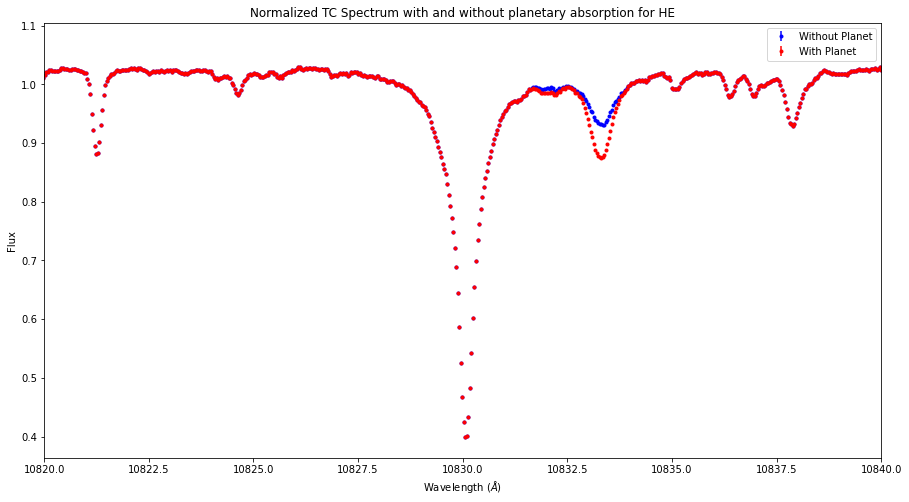

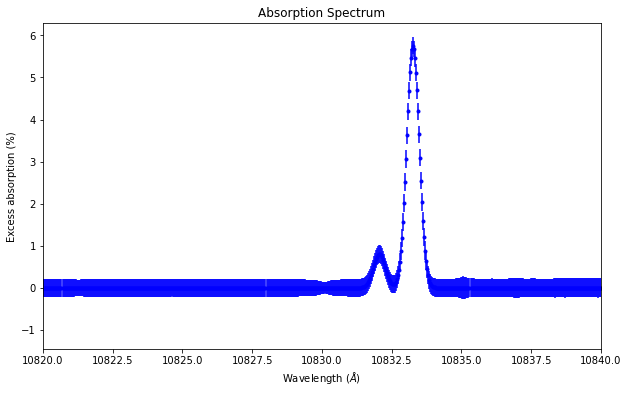

In [54]:
reload(AF)

#Random index of the spectrum to plot.
idx = 10

#Defining a variable to save or not the results.
save = False

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.
    
    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr_HE[idx], yerr = total_norm_err_HE[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = theoretical_err, fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption for HE')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr_HE[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err_HE[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (%)')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.

    theoretical_spctr = spec_mod.spectrum_he(ref_waveotal_norm_spctr[idx], temperature, density, vsini, medium, R_pow = R_power)
    theoretical_err = spec_mod.spectrum_he(ref_waveotal_norm_err[idx], temperature, density, vsini, medium, R_pow = R_power)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_waveotal_norm_spctr[idx], yerr = total_norm_err[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_waveheoretical_spctr, yerr = total_norm_err[idx], fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.tile('Absorption Spectrum')
    plt.ylabel('Excess absorption (\%)')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.show()




## Defining in-transit and out-of-transit parts of the timeseries

In [55]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):    
    
    #Defining the bounds of transit
    low_bound_HA = int(len(date_HA)/4)
    up_bound_HA = int(3*len(date_HA)/4)
    
    low_bound_HE = int(len(date_HE)/4)
    up_bound_HE = int(3*len(date_HE)/4)


    #Making the spectra
    #Before transit
    out_transit_spctr_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_err_HA)
    #In transit
    in_transit_spctr_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_spctr_HA)
    in_transit_err_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_err_HA)
    #After transit
    out_transit_spctr_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_err_HA)
    #Out-of-transit
    out_transit_spctr_HA = np.concatenate((out_transit_spctr_HA_1, out_transit_spctr_HA_2)) 
    out_transit_err_HA = np.concatenate((out_transit_err_HA_1, out_transit_err_HA_2)) 

    #Before transit
    out_transit_spctr_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_err_HE)
    #In transit
    in_transit_spctr_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_spctr_HE)
    in_transit_err_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_err_HE)
    #After transit
    out_transit_spctr_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_err_HE)
    #Out-of-transit
    out_transit_spctr_HE = np.concatenate((out_transit_spctr_HE_1, out_transit_spctr_HE_2)) 
    out_transit_err_HE = np.concatenate((out_transit_err_HE_1, out_transit_err_HE_2)) 
  
    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, date_HA)
    date_in_transit_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, date_HE)

#If there is one mode of observation
else:    
    #Defining the bounds of transit
    low_bound = int(len(date)/4)
    up_bound = int(3*len(date)/4)
 
    #Making the spectra
    #Before transit
    out_transit_spctr_1 = AF.bound(date[0], date[low_bound], date, total_norm_spctr)
    out_transit_err_1 = AF.bound(date[0], date[low_bound], date, total_norm_err)
    #In transitc
    in_transit_spctr = AF.bound(date[low_bound], date[up_bound], date, total_norm_spctr)
    in_transit_err = AF.bound(date[low_bound], date[up_bound], date, total_norm_err)
    #After transit
    out_transit_spctr_2 = AF.bound(date[up_bound], date[-1], date, total_norm_spctr)
    out_transit_err_2 = AF.bound(date[up_bound], date[-1], date, total_norm_err)
    #Out-of-transit
    out_transit_spctr = np.concatenate((out_transit_norm_spctr_1, out_transit_norm_spctr_2)) 
    out_transit_err = np.concatenate((out_transit_norm_err_1, out_transit_norm_err_2)) 

    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit = AF.bound(date[low_bound], date[up_bound], date, date)


## Adding the planetary signal during the transit

In [56]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr_HA = np.ones(in_transit_spctr_HA.shape)
    planet_in_transit_err_HA = np.ones(in_transit_err_HA.shape)
    
    planet_in_transit_spctr_HE = np.ones(in_transit_spctr_HE.shape)
    planet_in_transit_err_HE = np.ones(in_transit_err_HE.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr_HA)):

        planet_in_transit_spctr_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
        planet_in_transit_err_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
    
    for i in range(len(in_transit_spctr_HE)):

        planet_in_transit_spctr_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)
        planet_in_transit_err_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)

#If there is one mode of observation    
else:
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr = np.ones(in_transit_spctr.shape)
    planet_in_transit_err = np.ones(in_transit_err.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr)):

        planet_in_transit_spctr[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr[i], temperature, density, vsini, medium, R_pow = R_power)
        planet_in_transit_err[i] = spec_mod.spectrum_he(ref_wave, in_transit_err[i], temperature, density, vsini, medium, R_pow = R_power)



## Getting the master spectrum in and out of transit

In [57]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit_HA = np.average(planet_in_transit_spctr_HA, axis=0, weights = 1/planet_in_transit_err_HA**2)
    master_err_intransit_HA = 1/np.sqrt(np.sum(1/planet_in_transit_err_HA**2, axis=0))
    
    master_planet_intransit_HE = np.average(planet_in_transit_spctr_HE, axis=0, weights = 1/planet_in_transit_err_HE**2)
    master_err_intransit_HE = 1/np.sqrt(np.sum(1/planet_in_transit_err_HE**2, axis=0))

    #Out-of-transit
    master_outtransit_HA = np.average(out_transit_spctr_HA, axis=0, weights = 1/out_transit_err_HA**2)
    master_err_outtransit_HA = 1/np.sqrt(np.sum(1/out_transit_err_HA**2, axis=0))
    
    master_outtransit_HE = np.average(out_transit_spctr_HE, axis=0, weights = 1/out_transit_err_HE**2)
    master_err_outtransit_HE = 1/np.sqrt(np.sum(1/out_transit_err_HE**2, axis=0))
    
#If there is one mode of observation
else:
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit = np.average(planet_in_transit_spctr, axis=0, weights = 1/planet_in_transit_err**2)
    master_err_intransit = 1/np.sqrt(np.sum(1/planet_in_transit_err**2, axis=0))

    #Out-of-transit
    master_outtransit = np.average(out_transit_spctr, axis=0, weights = 1/out_transit_err**2)
    master_err_outtransit = 1/np.sqrt(np.sum(1/out_transit_err**2, axis=0))
    

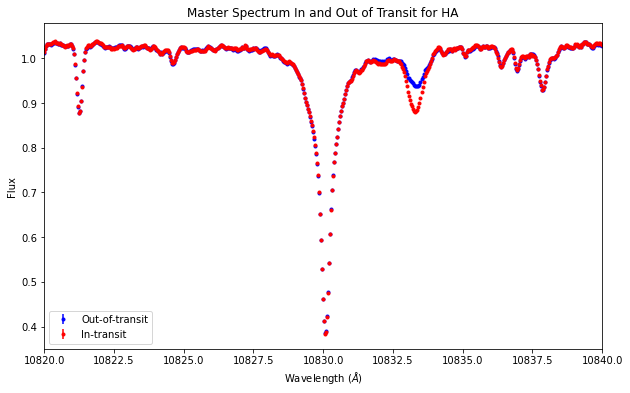

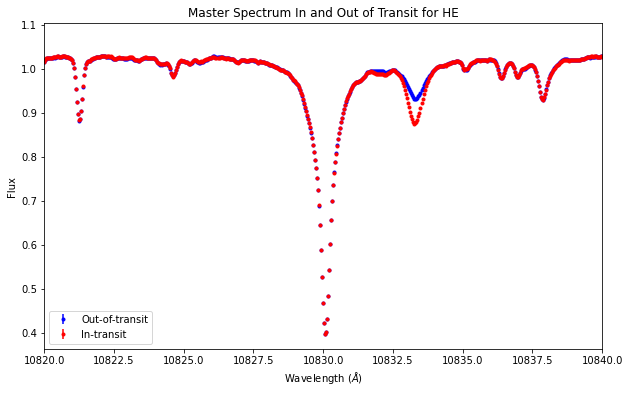

In [58]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HA, yerr = master_err_outtransit_HA, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HA, yerr = master_err_intransit_HA, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HA')
    plt.xlim([10820, 10840])
    plt.show()

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HE, yerr = master_err_outtransit_HE, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HE, yerr = master_err_intransit_HE, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HE')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit, yerr = master_err_outtransit, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit, yerr = master_err_intransit, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit')
    plt.xlim([10820, 10840])
    plt.show()


## Retrieving the planetary parameters once again

In [59]:
reload(AF)

##Defining the difference between the in-transit and master out-of-transit spectra to get 
#a time series of the planet's spectrum
offset = 1

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff_HA = np.ones(planet_in_transit_spctr_HA.shape)
    diff_HA_err = np.ones(planet_in_transit_err_HA.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr_HA)):
        diff_HA[i] = offset+(master_outtransit_HA - planet_in_transit_spctr_HA[i])/master_outtransit_HA
        diff_HA_err[i] = np.sqrt((planet_in_transit_err_HA[i]/master_outtransit_HA)**2 + ((planet_in_transit_spctr_HA[i] * master_err_outtransit_HA)/(master_outtransit_HA**2))**2)
        #diff_HA_err[i] = diff_HA[i] * np.sqrt((planet_in_transit_err_HA[i]/planet_in_transit_spctr_HA[i])**2 + (master_err_outtransit_HA/master_outtransit_HA)**2)
        #diff_HA_err[i] = np.sqrt(((master_outtransit_HA**2 * planet_in_transit_err_HA[i]**2)+(planet_in_transit_spctr_HA[i]**2 * master_err_outtransit_HA**2))/master_outtransit_HA**4)

    diff_HE = np.ones(planet_in_transit_spctr_HE.shape)
    diff_HE_err = np.ones(planet_in_transit_err_HE.shape)
    for i in range(len(planet_in_transit_spctr_HE)):
        diff_HE[i] = offset+(master_outtransit_HE - planet_in_transit_spctr_HE[i])/master_outtransit_HE
        diff_HE_err[i] = np.sqrt((planet_in_transit_err_HE[i]/master_outtransit_HE)**2 + ((planet_in_transit_spctr_HE[i] * master_err_outtransit_HE)/(master_outtransit_HE**2))**2)

#If there is one mode of observation
else:
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff = np.ones(planet_in_transit_spctr.shape)
    diff_err = np.ones(planet_in_transit_err.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr)):
        diff[i] = (master_outtransit - planet_in_transit_spctr[i])/master_outtransit
        diff_err[i] = np.sqrt((planet_in_transit_err[i]/master_outtransit)**2 + ((planet_in_transit_spctr[i] * master_err_outtransit)/(master_outtransit**2))**2)



/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15531725e+04 -6.36404627e+14]


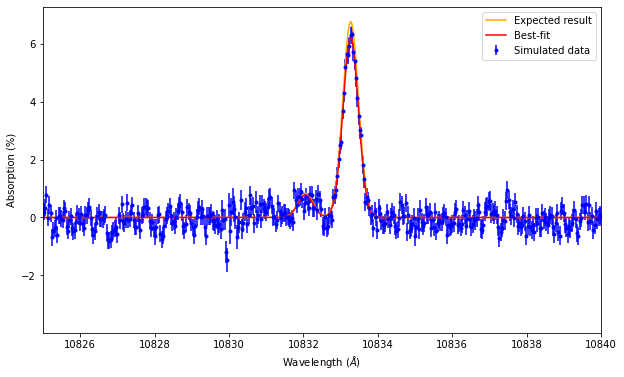

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01704953e+04 -6.15042269e+14]


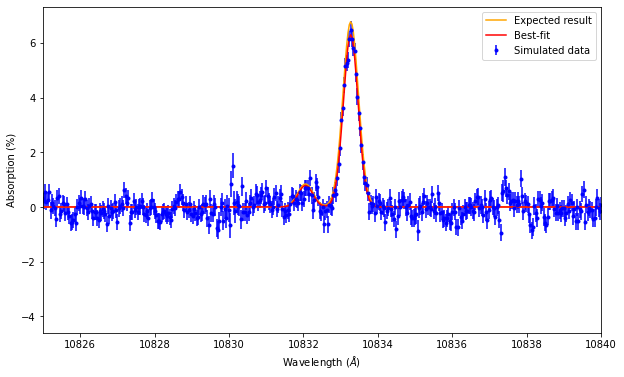

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12920450e+04 -6.28842546e+14]


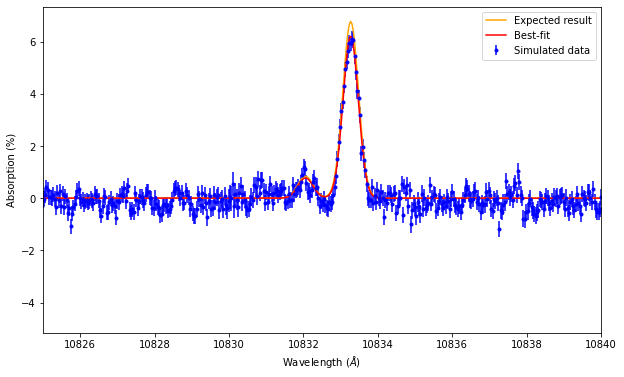

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15308542e+04 -6.39813802e+14]


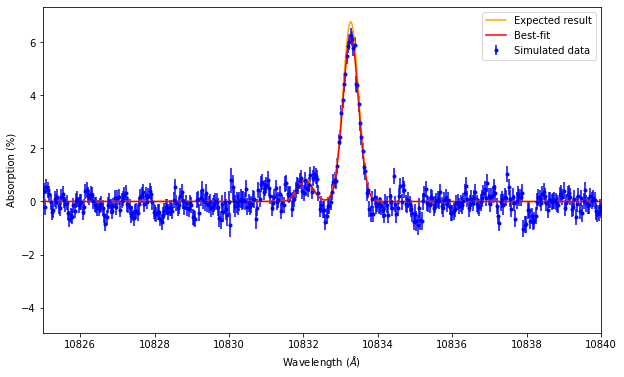

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05867376e+04 -6.26714036e+14]


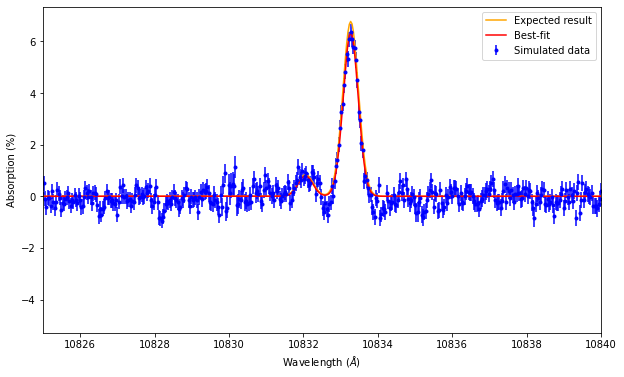

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13613304e+04 -6.28436243e+14]


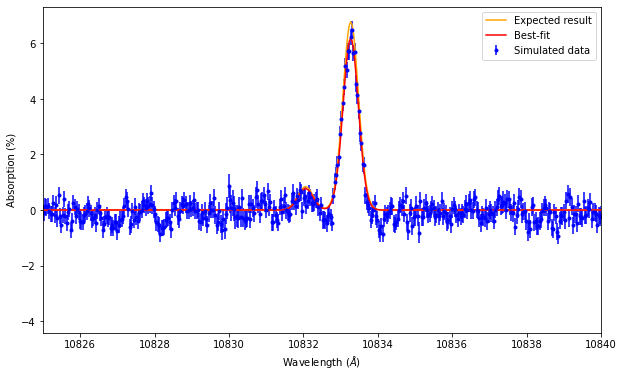

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12363678e+04 -6.32975218e+14]


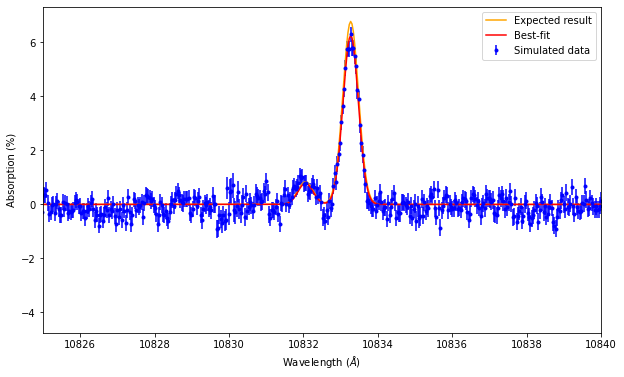

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.27428521e+04 -6.29047619e+14]


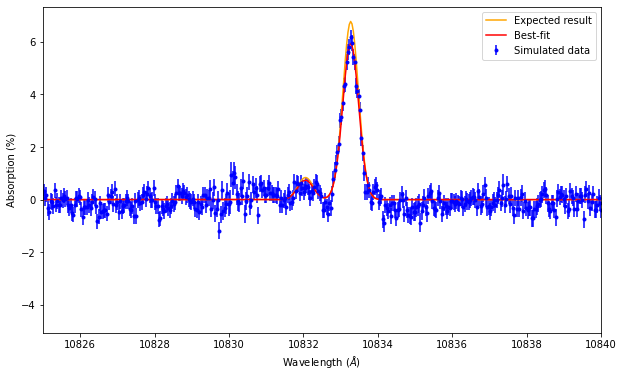

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13724276e+04 -6.31666922e+14]


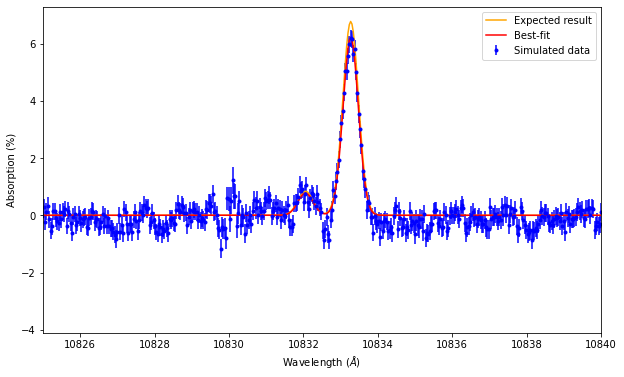

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.51956456e+03 -6.07487741e+14]


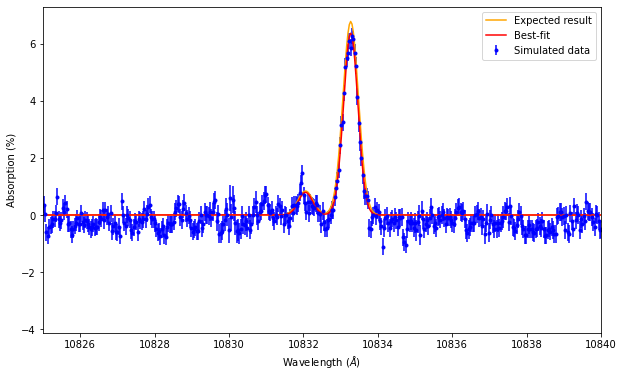

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06545607e+04 -6.22368030e+14]


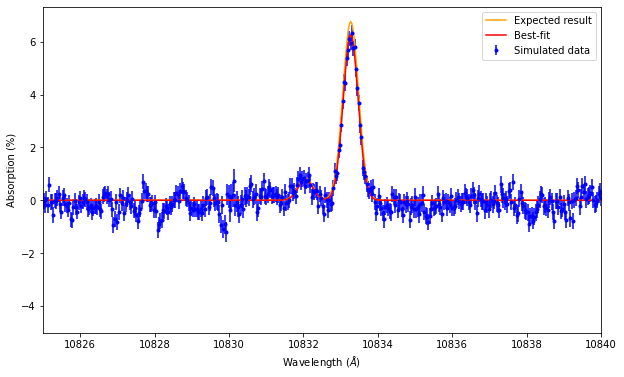

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03013398e+04 -6.29258966e+14]


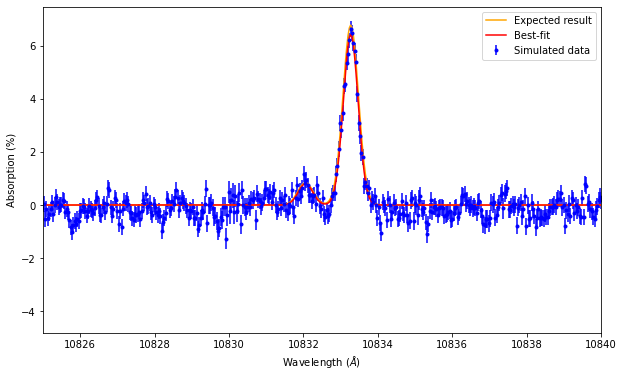

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11291407e+04 -6.35387510e+14]


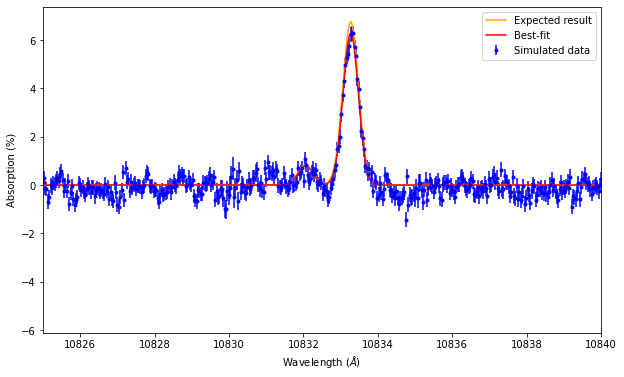

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08668818e+04 -6.24282260e+14]


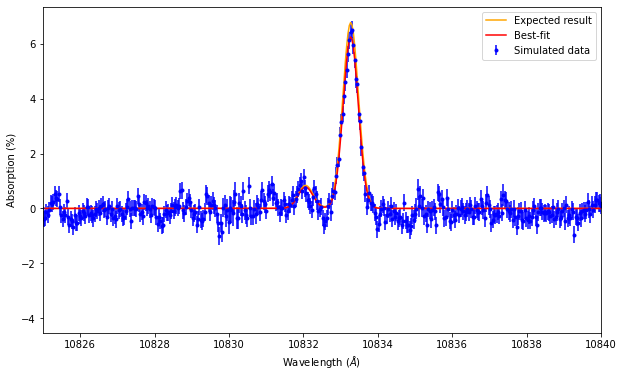

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07174001e+04 -6.08400558e+14]


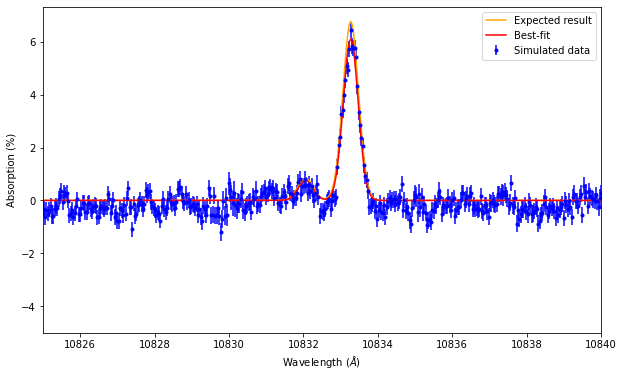

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18132492e+04 -6.26574346e+14]


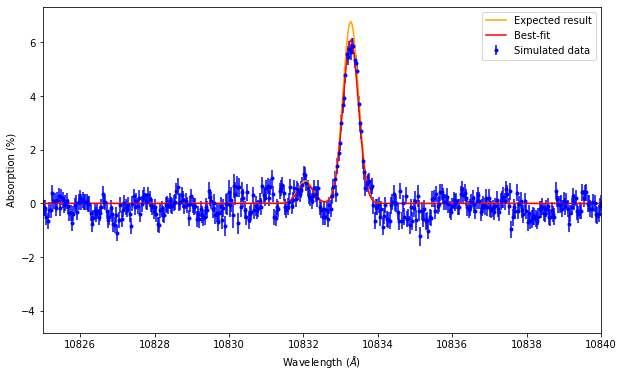

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.89504389e+03 -6.01171880e+14]


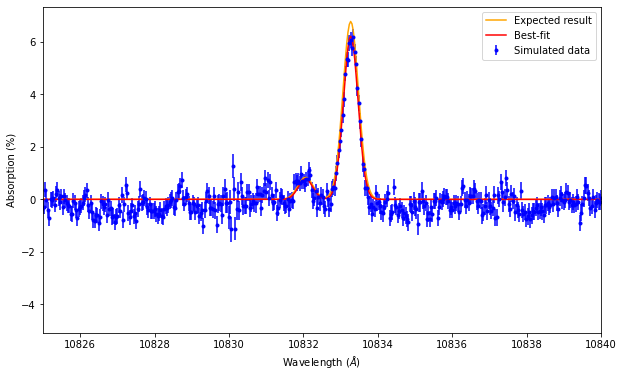

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15201893e+04 -6.12855558e+14]


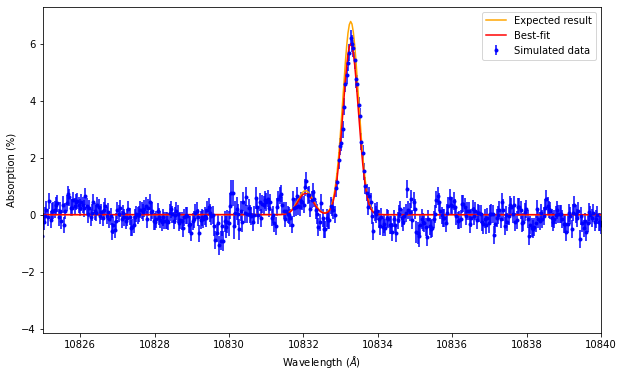

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09239362e+04 -6.04684181e+14]


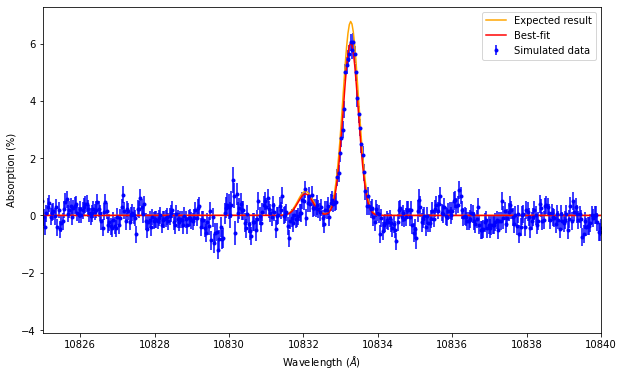

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17228933e+04 -6.03311965e+14]


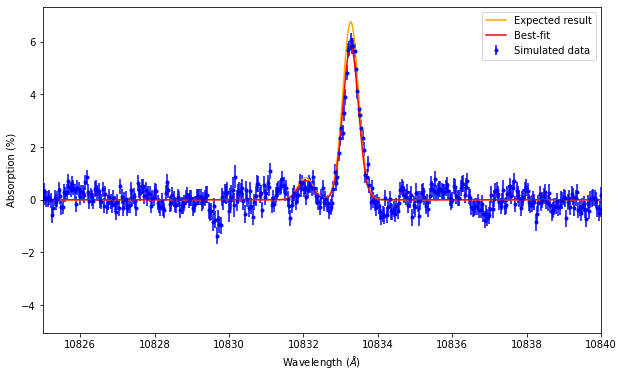

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09650261e+04 -6.19952052e+14]


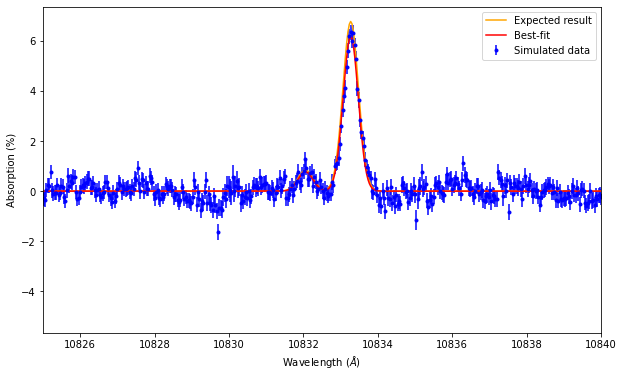

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05550029e+04 -6.23153652e+14]


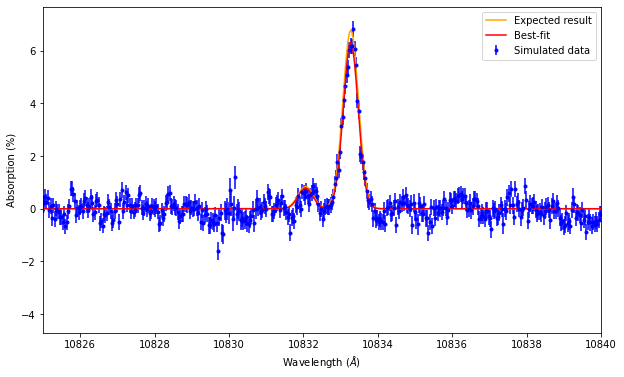

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09405496e+04 -6.02078652e+14]


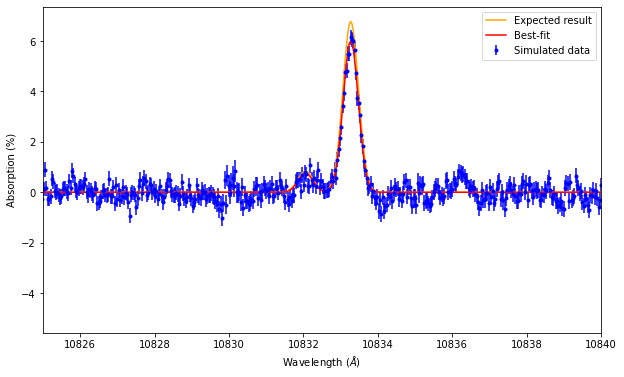

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.75977585e+03 -5.99525473e+14]


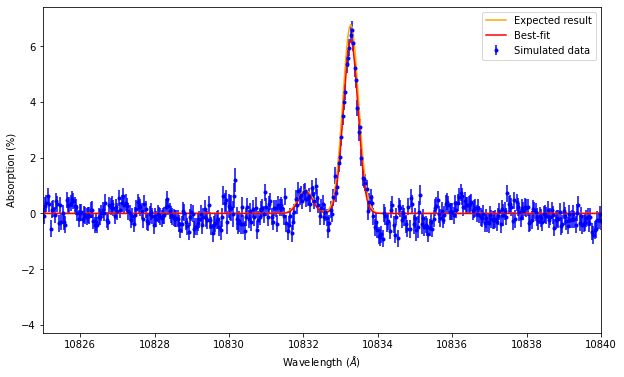

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14415815e+04 -6.60639754e+14]


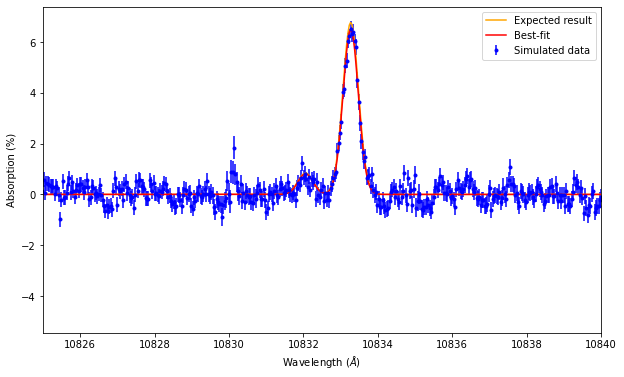

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15258949e+04 -6.32193691e+14]


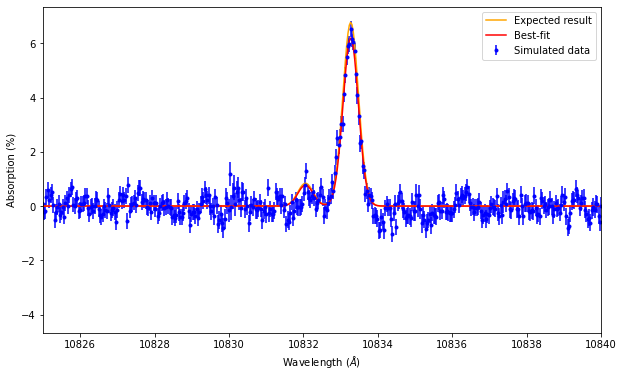

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.29388911e+03 -5.83704701e+14]


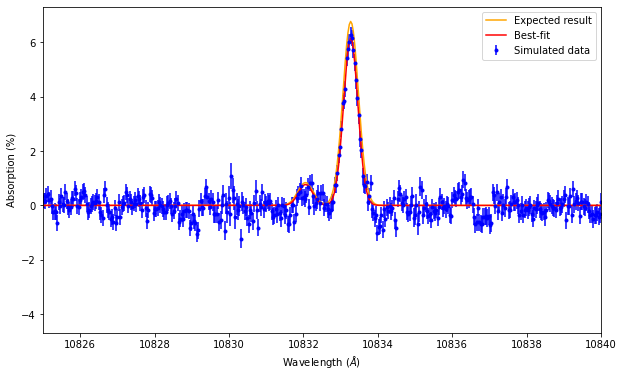

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14716128e+04 -6.36207573e+14]


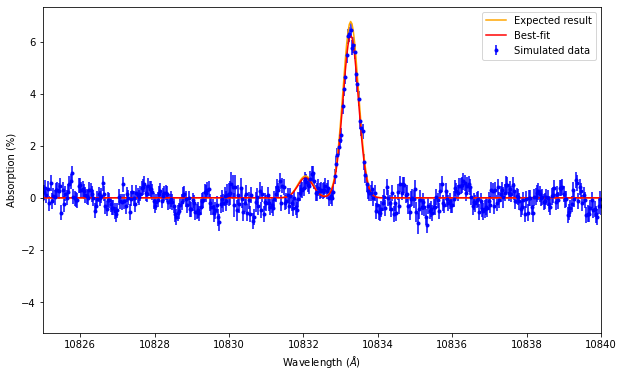

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.95618949e+03 -6.07764875e+14]


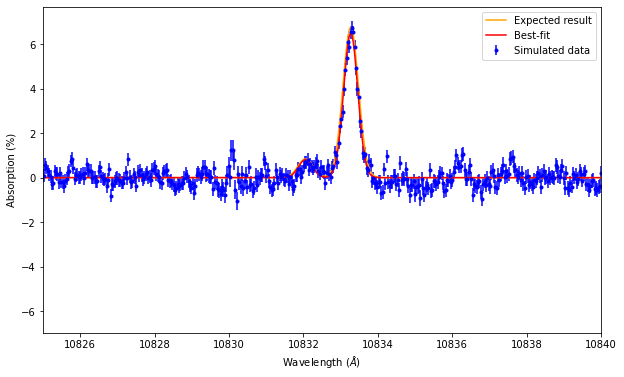

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03343441e+04 -6.51506081e+14]


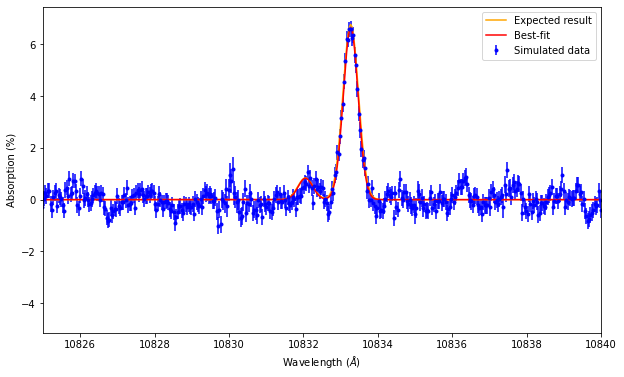

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11933811e+04 -6.33059712e+14]


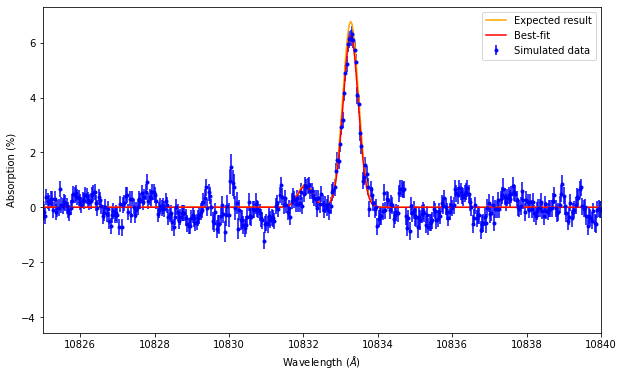

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04192702e+04 -6.30065031e+14]


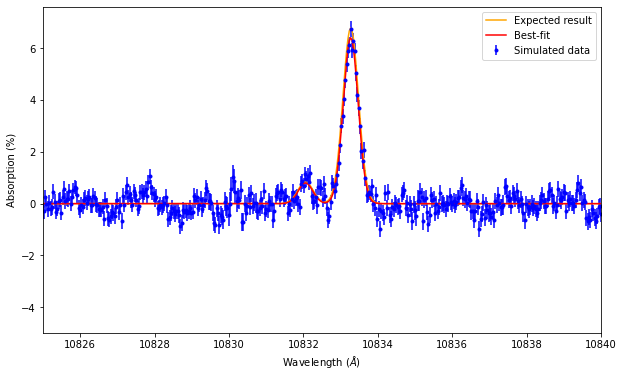

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.61791543e+03 -6.31659165e+14]


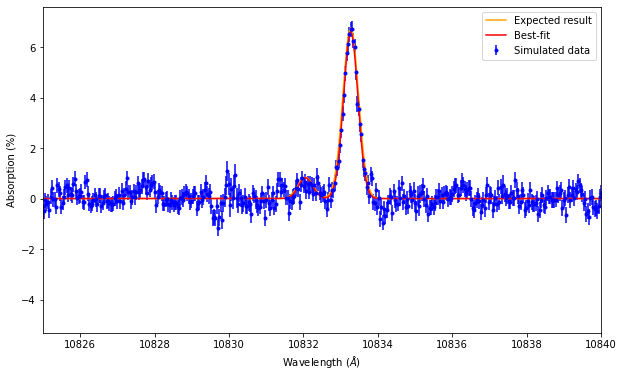

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03845721e+04 -6.43600007e+14]


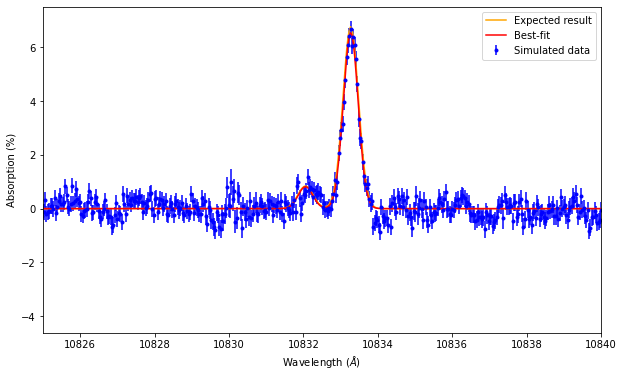

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13180694e+04 -6.30758469e+14]


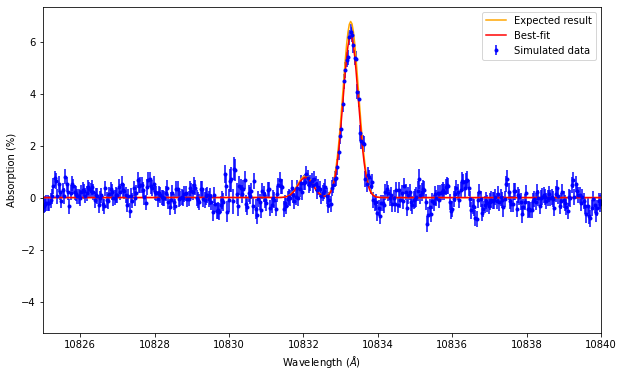

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11895349e+04 -6.51057538e+14]


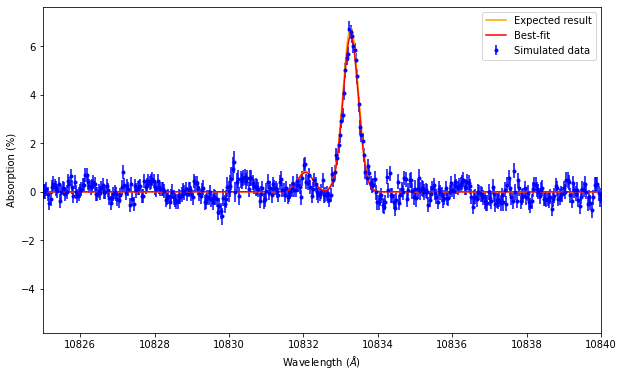

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11499445e+04 -6.32330862e+14]


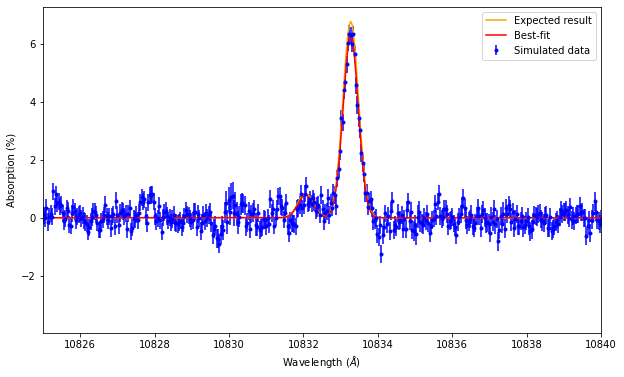

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.24894186e+04 -6.42499680e+14]


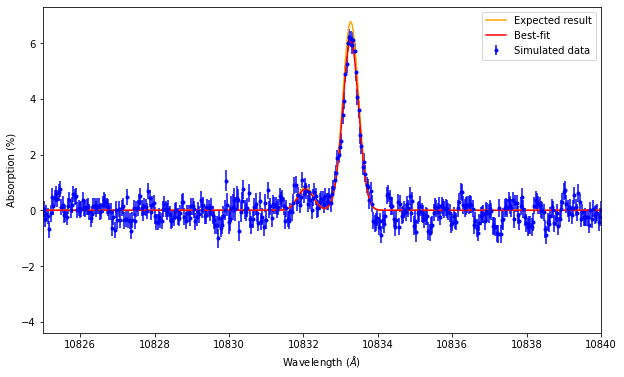

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.19998416e+04 -6.47271099e+14]


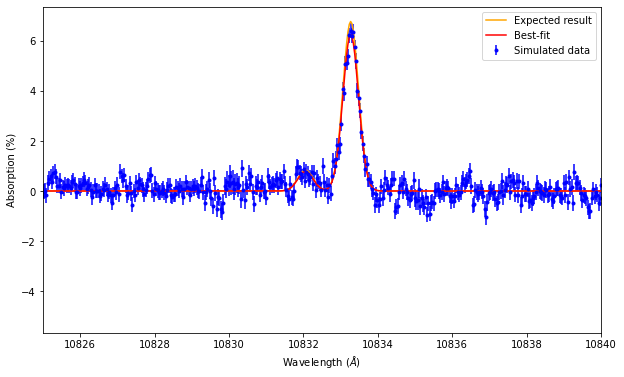

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.29166012e+04 -6.51802100e+14]


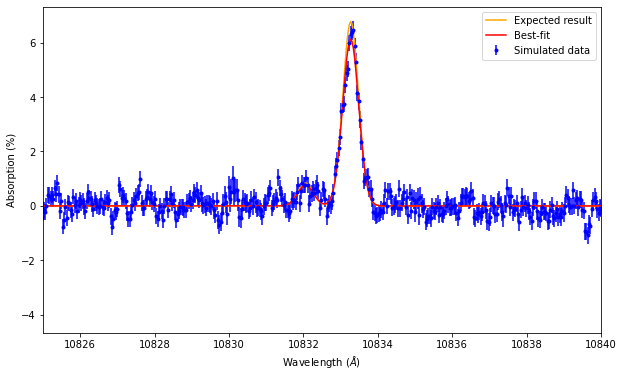

[ 1.39207974e+04 -6.67956400e+14]


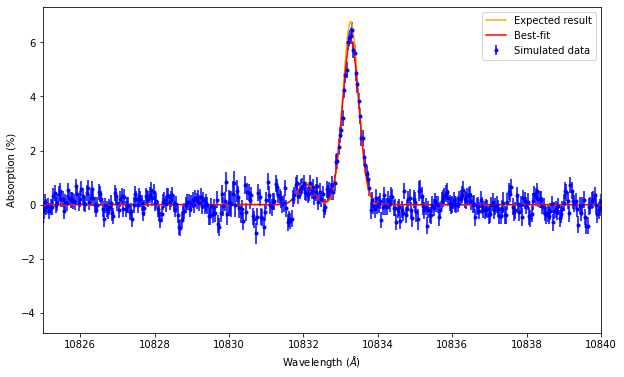

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20862812e+04 -6.72443940e+14]


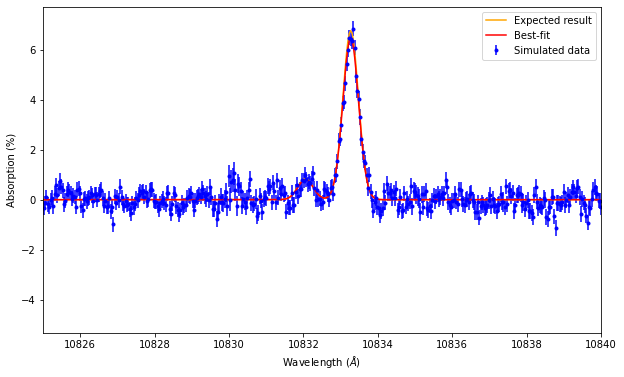

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16135183e+04 -6.44912028e+14]


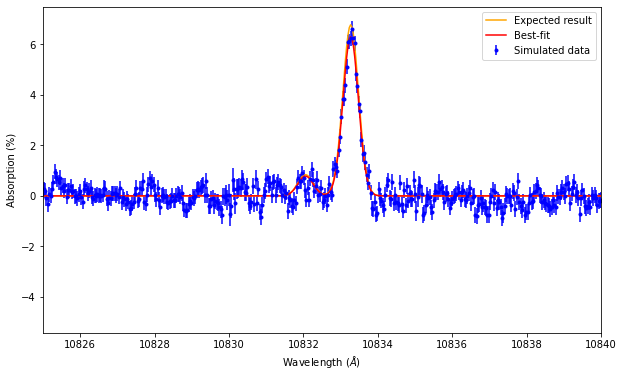

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22844665e+04 -6.48556714e+14]


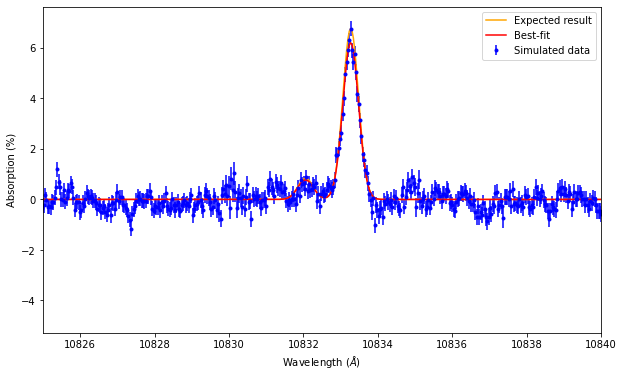

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.32593573e+04 -6.39266961e+14]


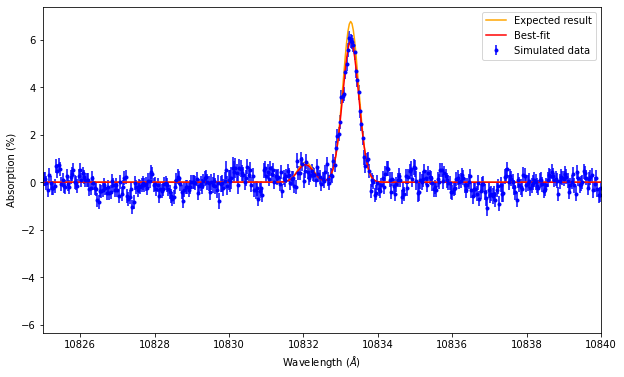

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.26877149e+04 -6.45496714e+14]


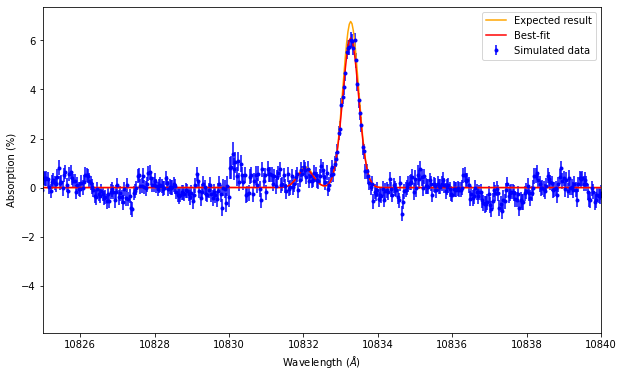

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.24233538e+04 -6.43203036e+14]


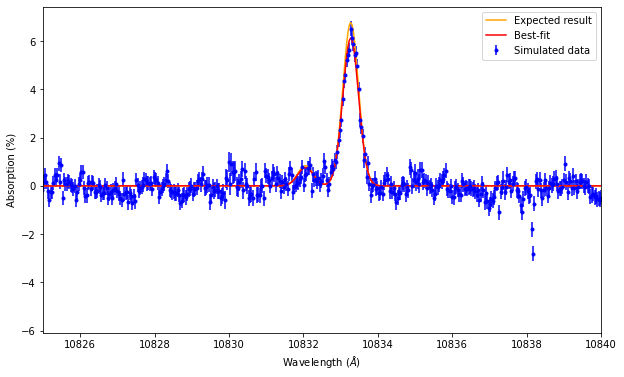

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.29771227e+04 -6.51824447e+14]


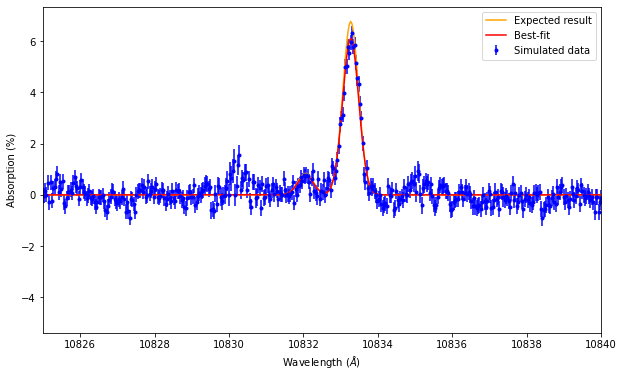

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.27362681e+04 -6.23218565e+14]


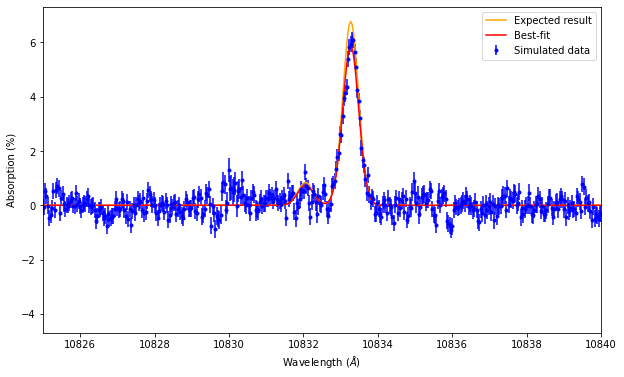

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13281139e+04 -6.29604867e+14]


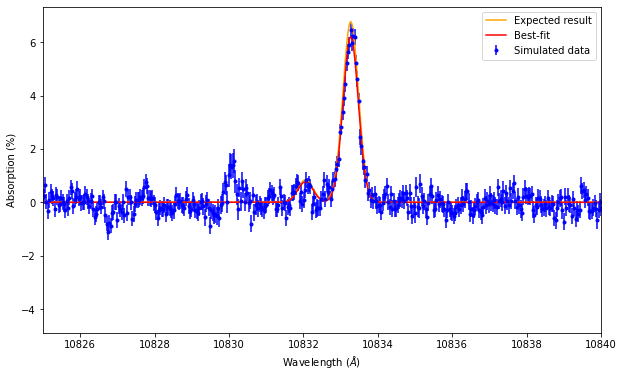

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22338493e+04 -6.31705952e+14]


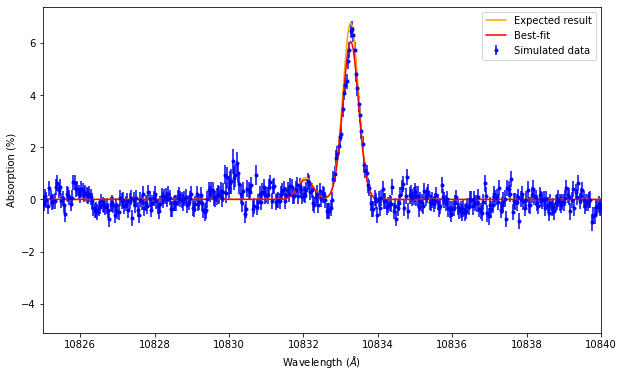

[ 1.37205660e+04 -6.53396453e+14]


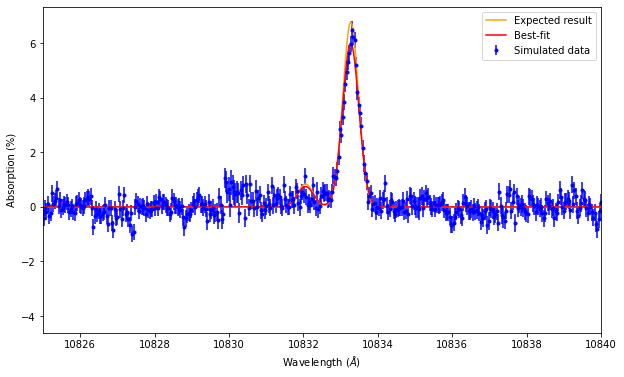

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16236780e+04 -6.32535551e+14]


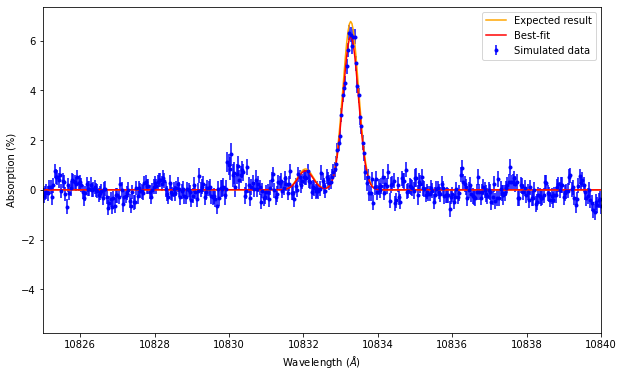

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06921819e+04 -6.38132600e+14]


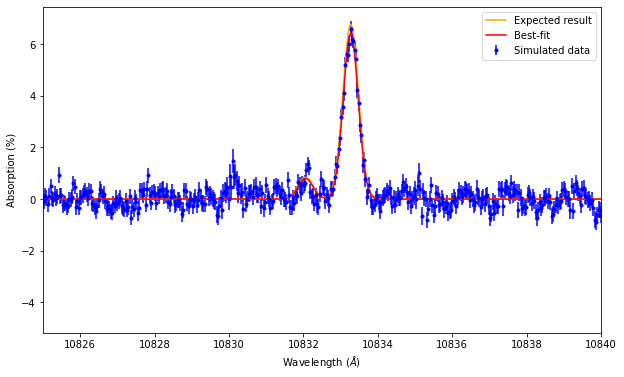

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15936018e+04 -6.35321323e+14]


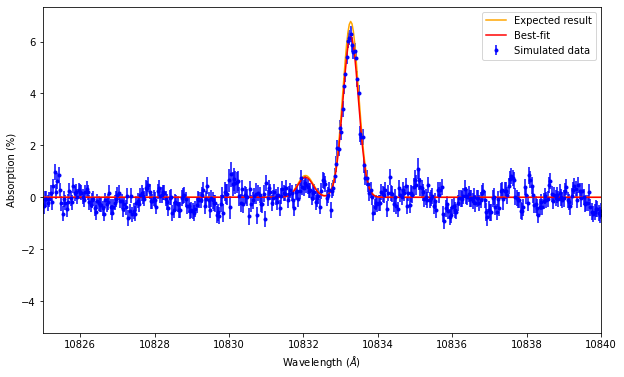

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22920113e+04 -6.33644044e+14]


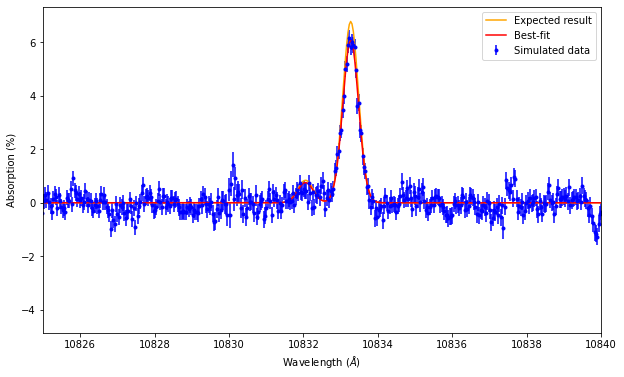

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12746202e+04 -6.26610021e+14]


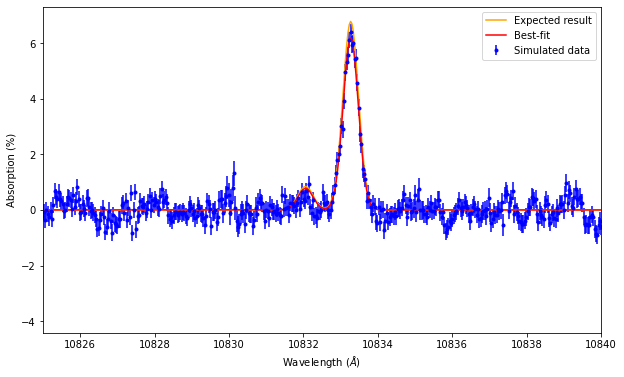

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15693802e+04 -6.25683283e+14]


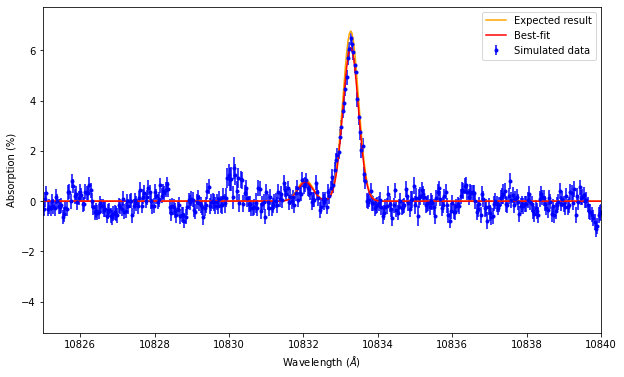

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10807935e+04 -6.09617209e+14]


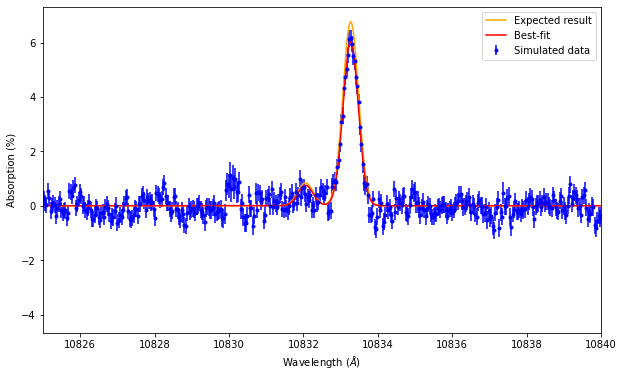

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02424577e+04 -6.25021455e+14]


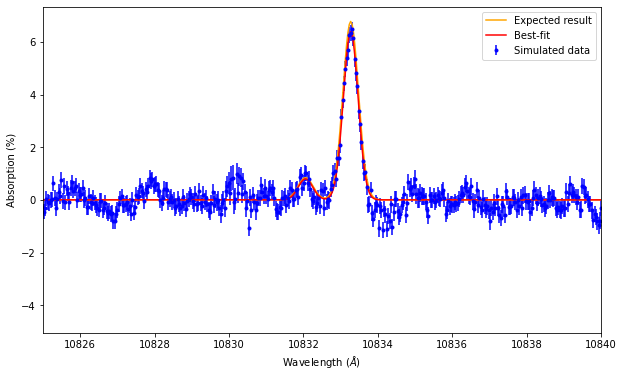

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04920380e+04 -6.04056633e+14]


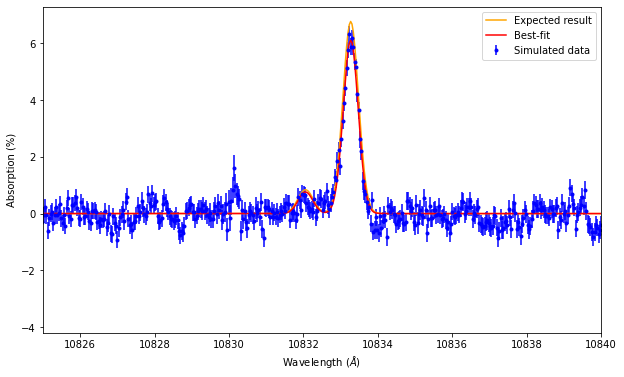

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.29464146e+04 -6.36937407e+14]


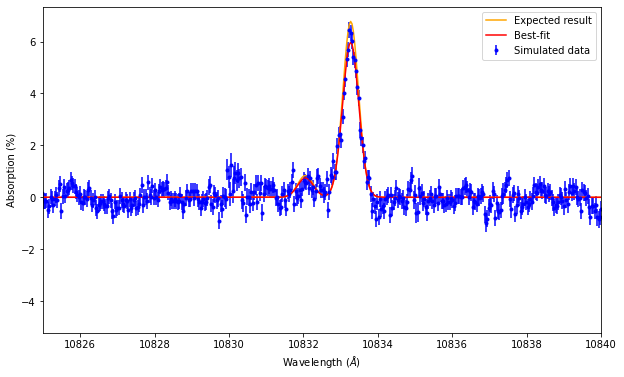

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22622856e+04 -6.56579412e+14]


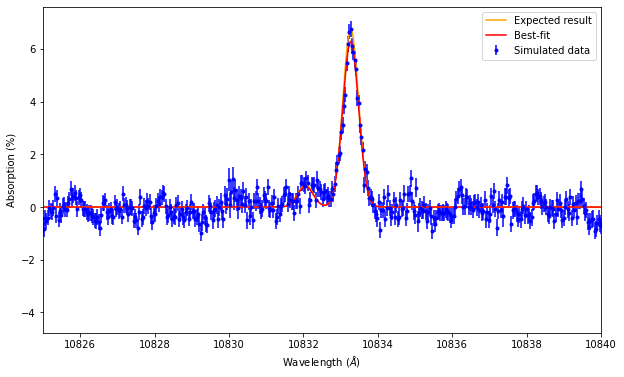

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15367293e+04 -6.59046123e+14]


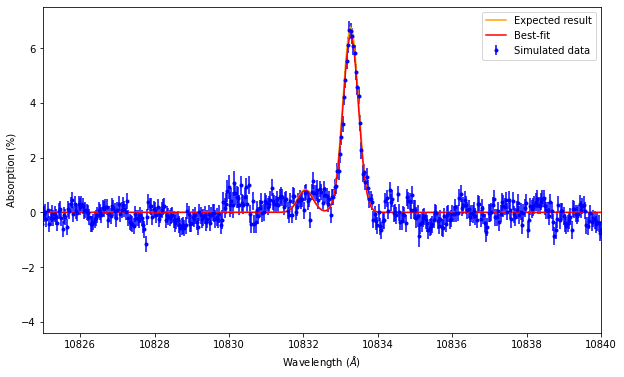

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20176065e+04 -6.58117796e+14]


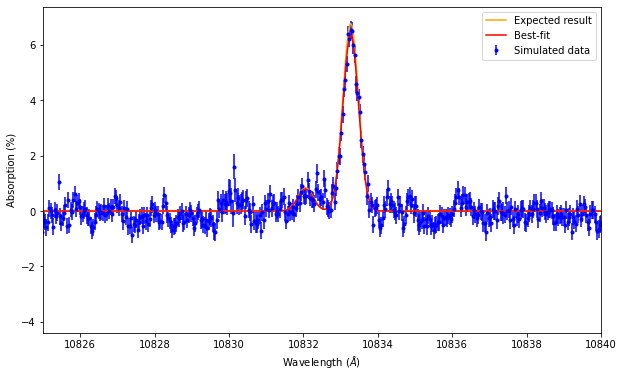

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08370685e+04 -6.22365115e+14]


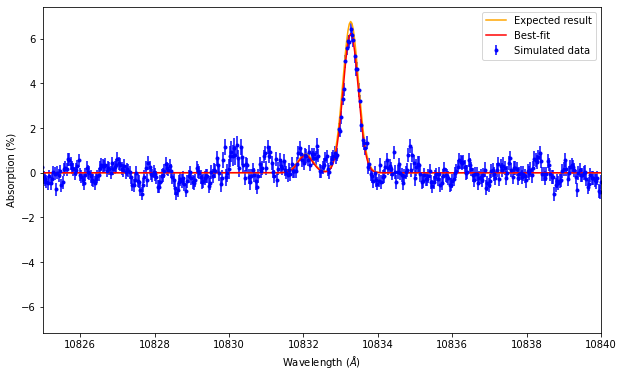

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09201299e+04 -6.38147133e+14]


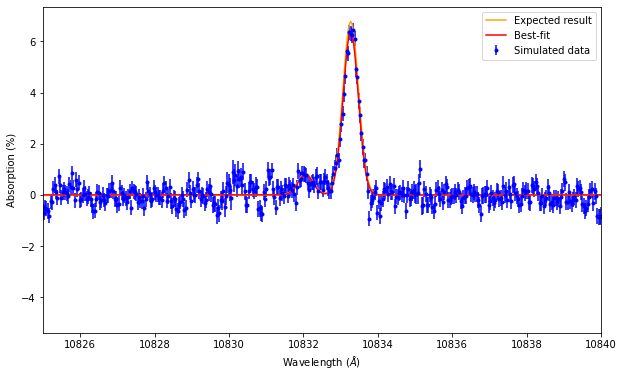

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.21752729e+04 -6.47937487e+14]


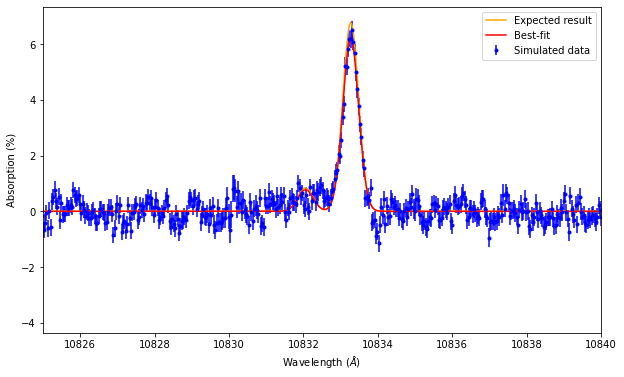

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07597526e+04 -6.18697083e+14]


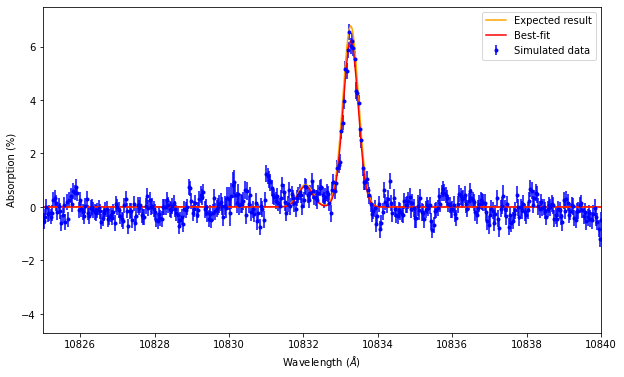

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04330476e+04 -6.17265540e+14]


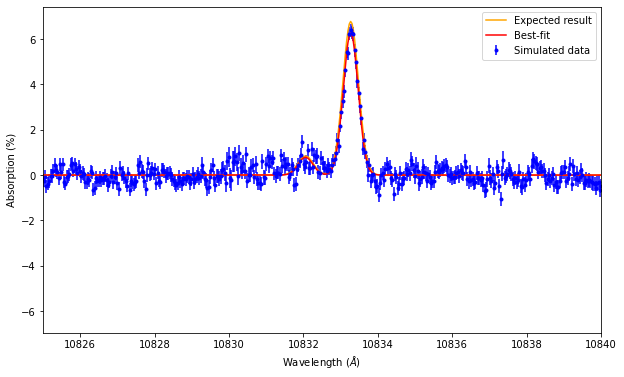

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04487498e+04 -6.32077085e+14]


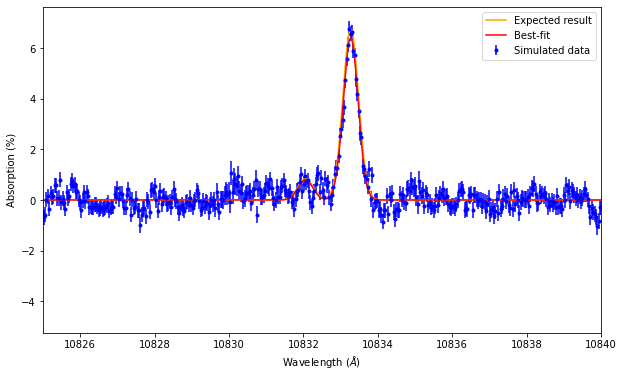

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17362069e+04 -6.57422616e+14 -9.48933340e-04]


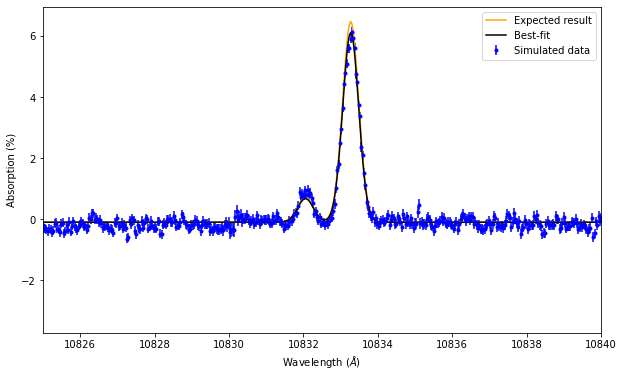

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.25433622e+04 -6.73721913e+14 -1.64724226e-03]


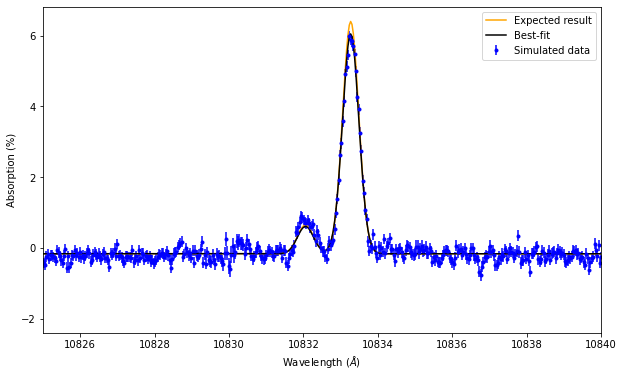

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23570322e+04 -6.67668977e+14 -1.47254455e-04]


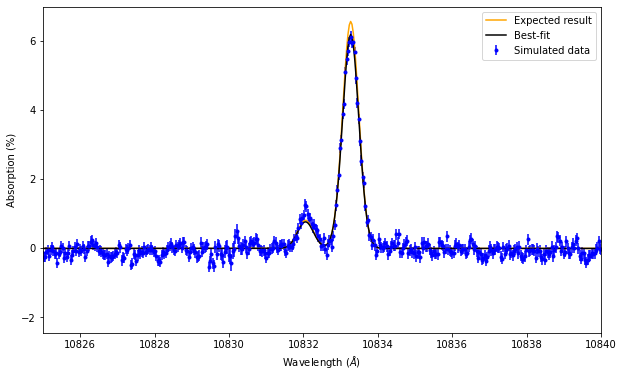

[ 1.41630147e+04 -7.20390048e+14 -1.07256741e-03]


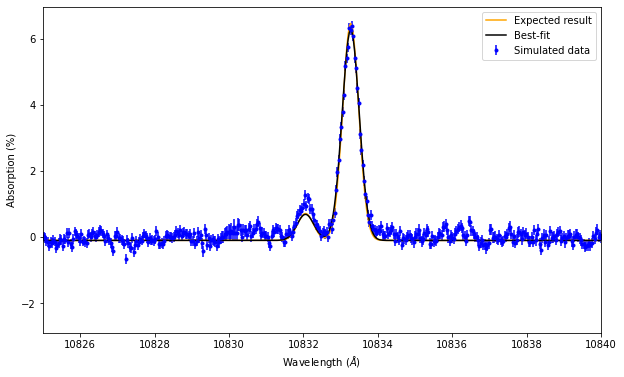

[ 1.36870057e+04 -7.13682847e+14  8.61918766e-05]


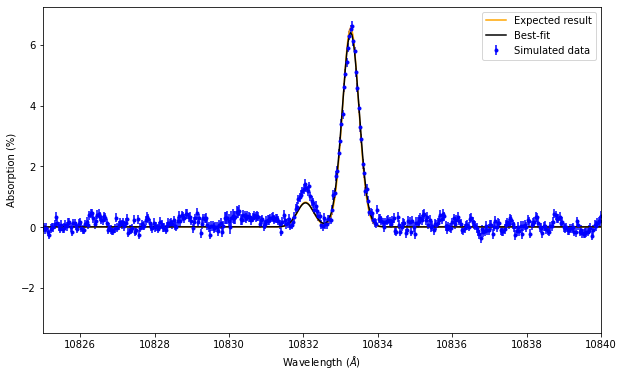

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.28884958e+04 -6.82005338e+14  1.52685596e-03]


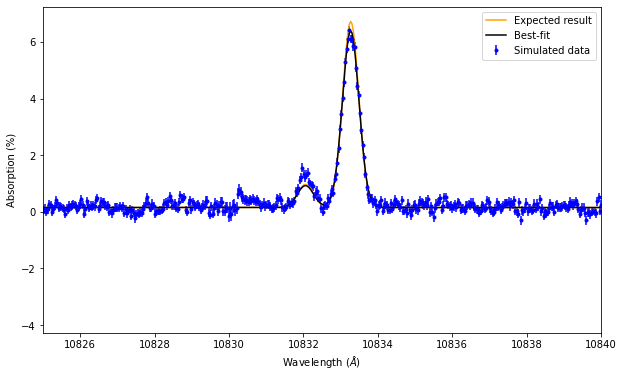

[ 1.35849541e+04 -7.07761640e+14  1.80833812e-05]


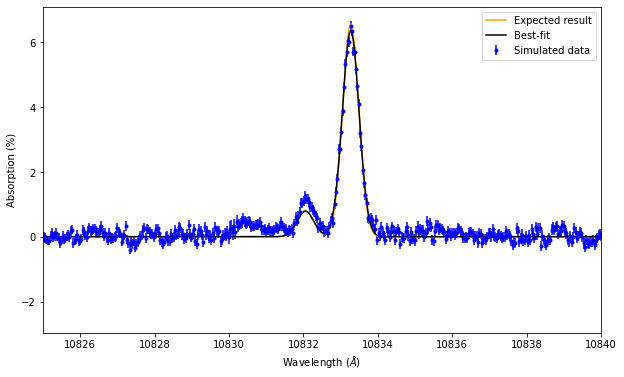

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.3325190e+04 -7.0018241e+14  2.7831728e-04]


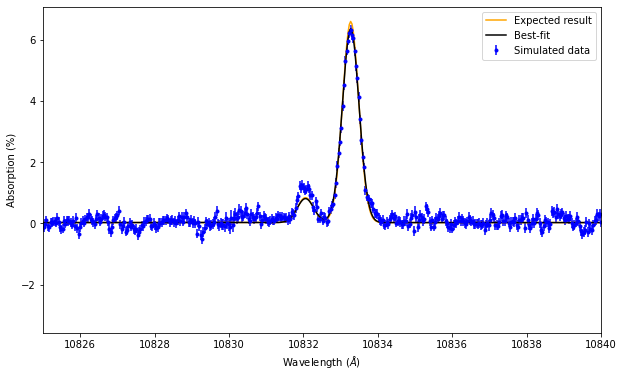

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23118731e+04 -6.65373618e+14 -2.01589492e-03]


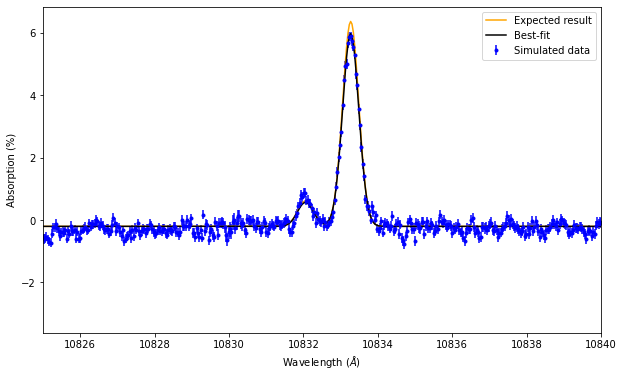

[ 1.36019449e+04 -7.10365351e+14  9.02394230e-04]


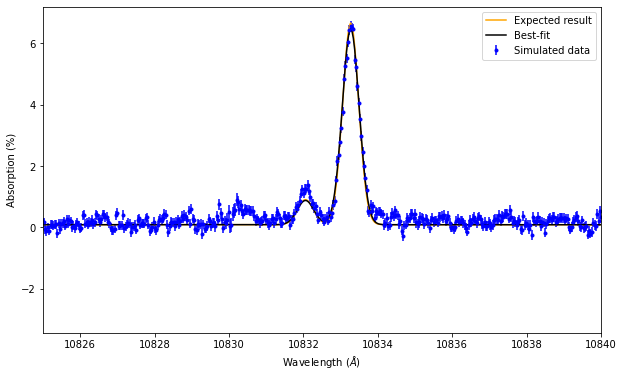

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17075386e+04 -6.61068024e+14 -3.23009043e-03]


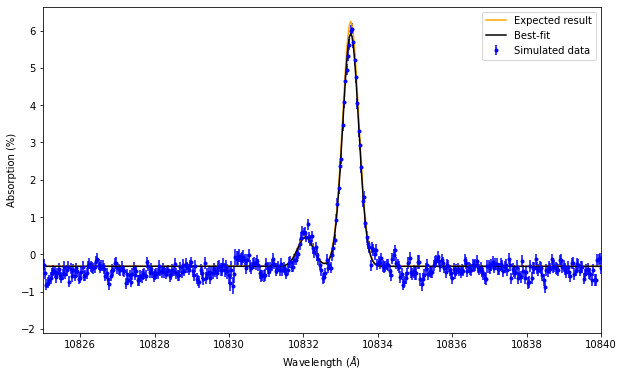

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.29306194e+04 -6.84039645e+14 -4.58736339e-04]


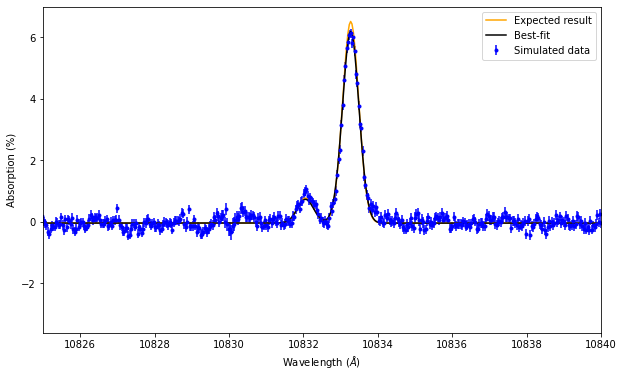

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23786169e+04 -6.77167681e+14 -1.13199619e-03]


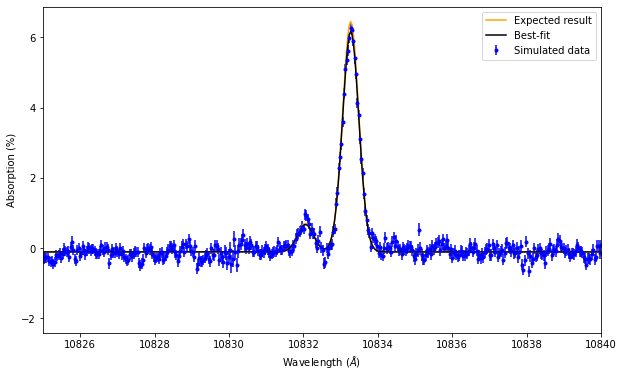

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.30245572e+04 -6.72082621e+14 -2.66201726e-04]


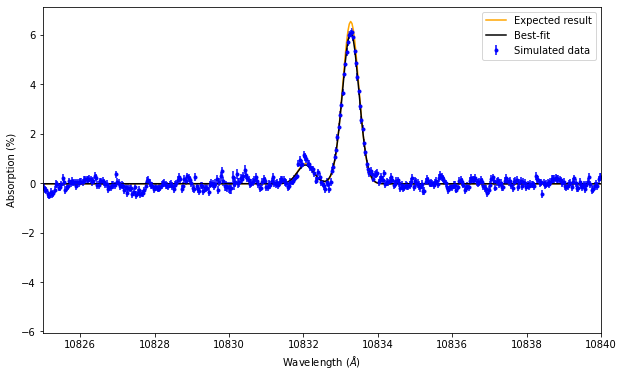

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.25298319e+04 -6.84706031e+14  7.07735537e-04]


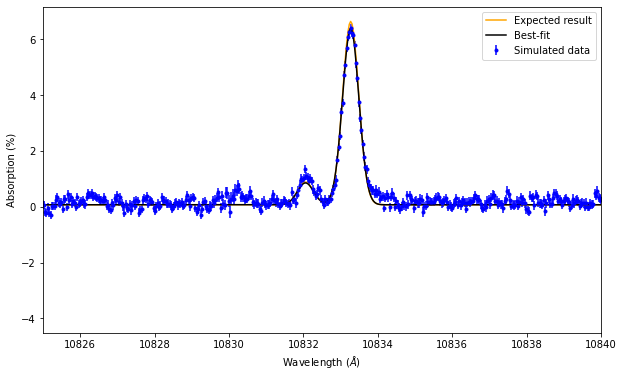

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.24601987e+04 -6.81791932e+14 -2.73361452e-03]


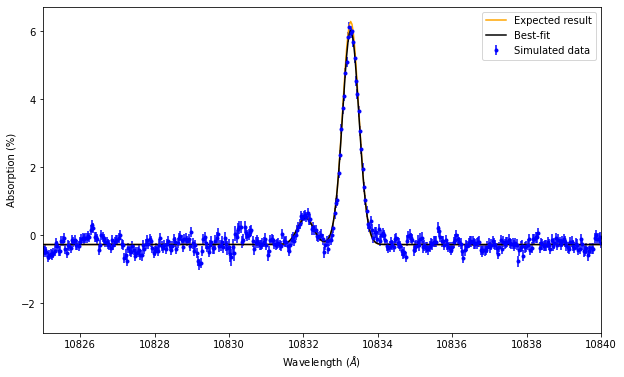

[ 1.36680946e+04 -7.03758437e+14  9.25649902e-04]


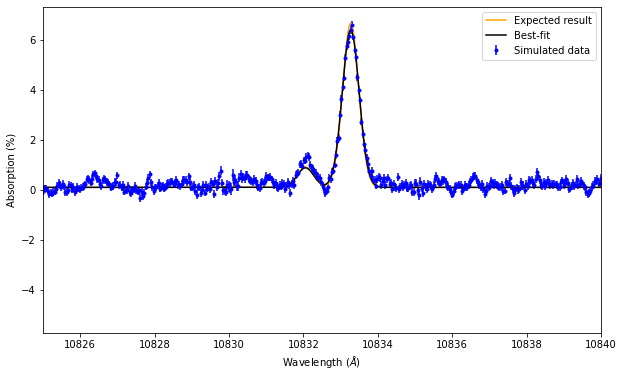

[ 1.41590961e+04 -7.17871482e+14  2.43012558e-03]


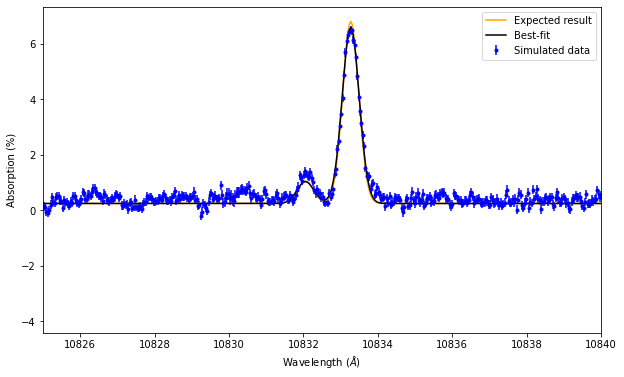

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.28597420e+04 -6.74414030e+14 -2.77936293e-03]


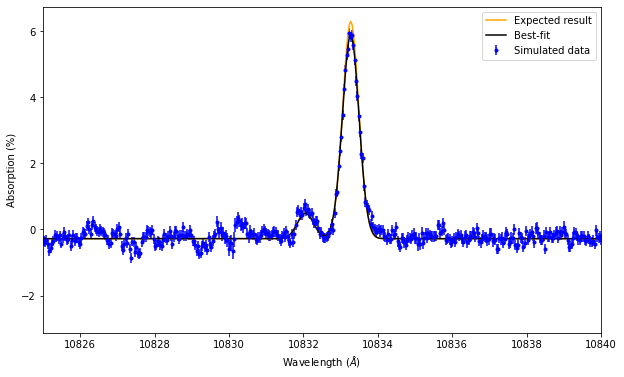

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.26759489e+04 -6.69909435e+14 -5.07830344e-04]


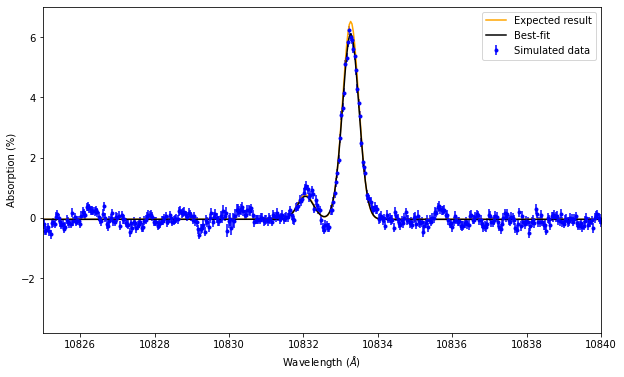

[ 1.33463053e+04 -6.95194684e+14 -5.79077124e-04]


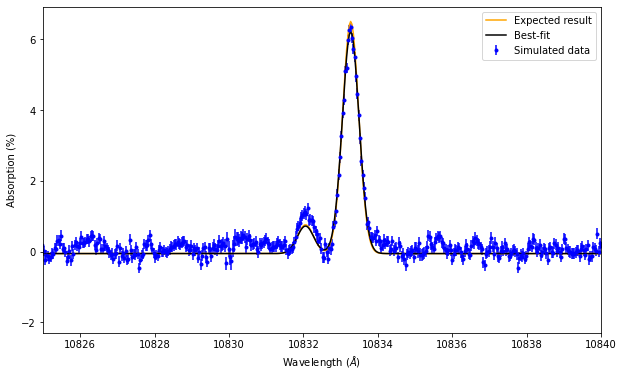

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.21788270e+04 -6.55823468e+14  1.41465188e-03]


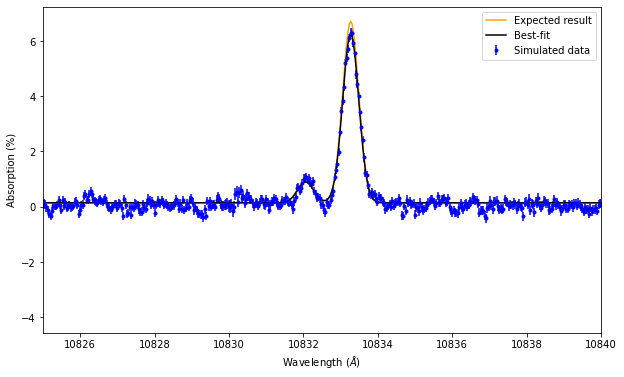

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.31216598e+04 -6.85336193e+14 -1.90675205e-03]


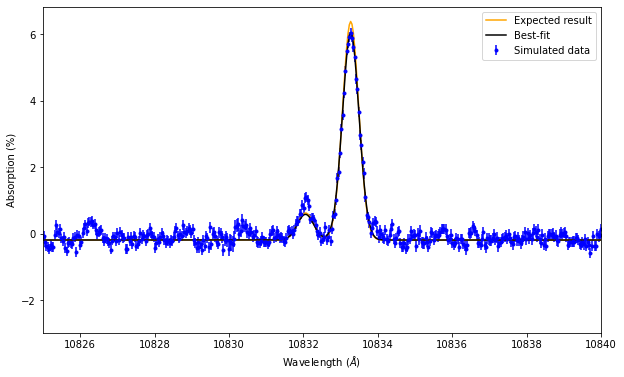

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.34752780e+04 -6.86990171e+14 -4.71237720e-04]


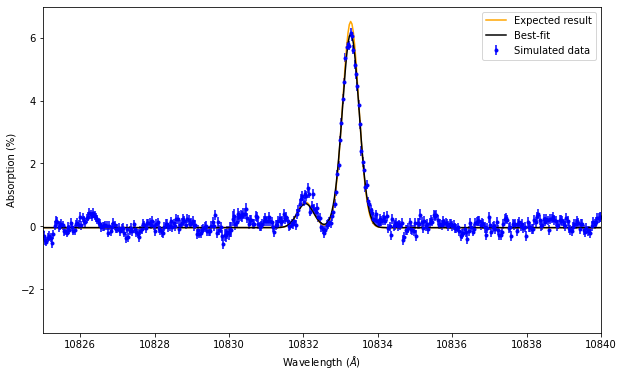

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.28253219e+04 -6.91536927e+14  8.01515130e-04]


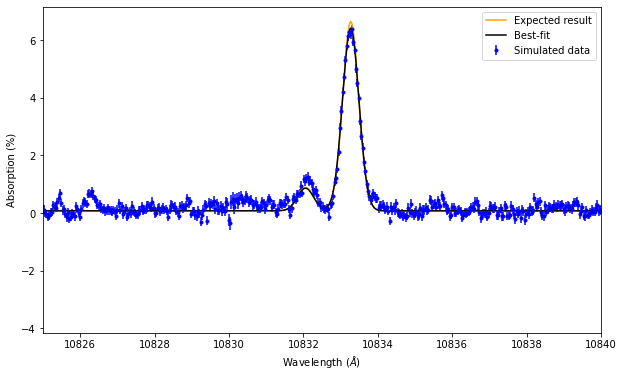

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.25238715e+04 -6.82393633e+14 -1.45463745e-03]


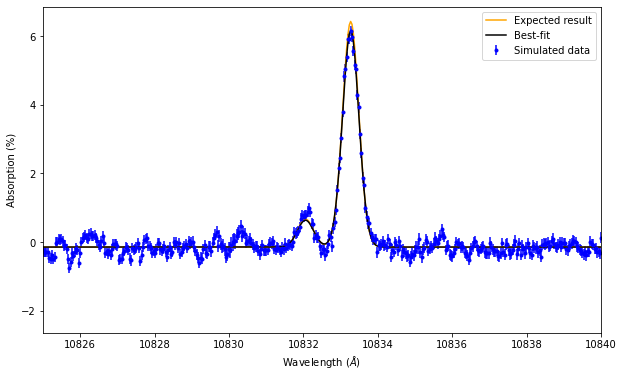

[ 1.43817585e+04 -7.09800763e+14  2.93202356e-03]


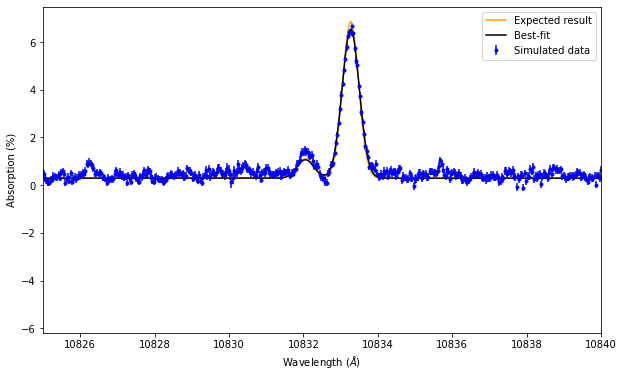

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.24571822e+04 -6.69560891e+14 -8.00498757e-04]


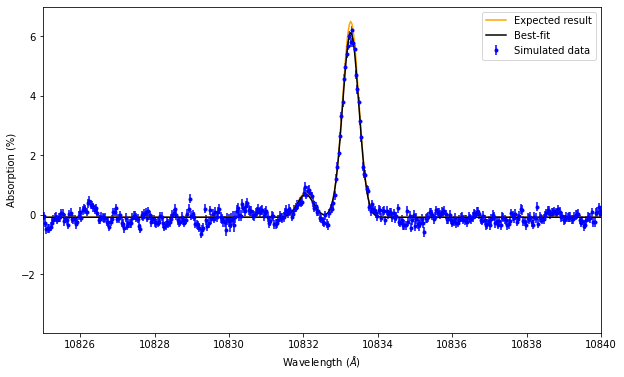

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.26151147e+04 -6.80387072e+14 -1.13914643e-03]


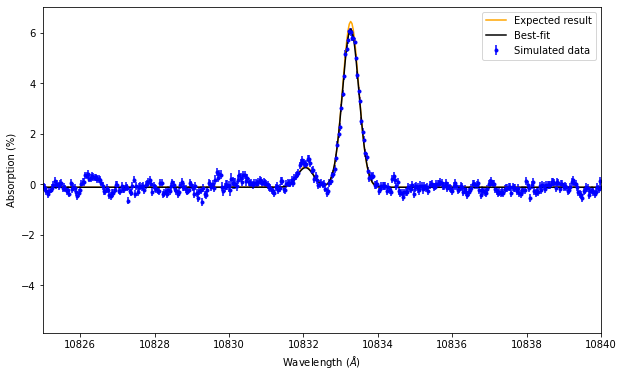

[ 1.36864334e+04 -6.90024436e+14  1.83176206e-03]


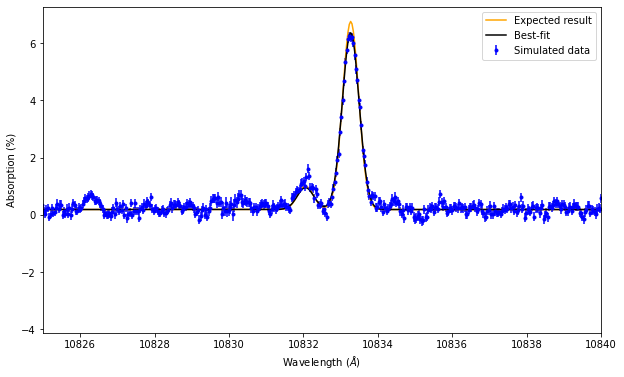

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.25460751e+04 -6.75516733e+14 -2.02303786e-03]


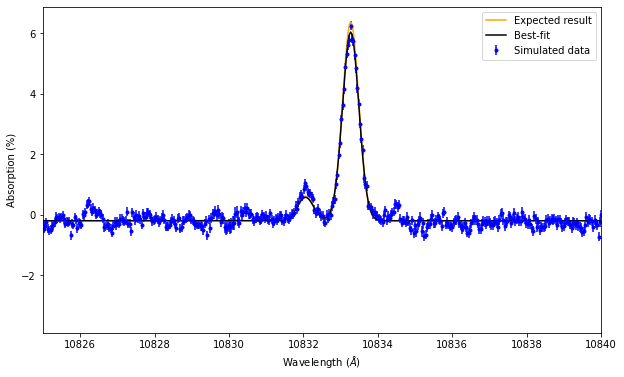

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.34509343e+04 -6.94229849e+14  7.16388391e-04]


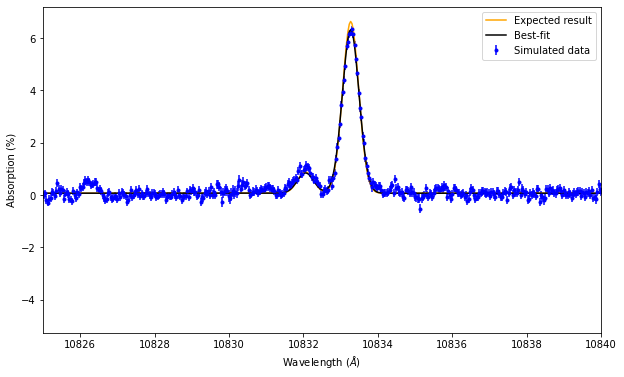

[ 1.33805393e+04 -6.76170291e+14 -1.56155169e-04]


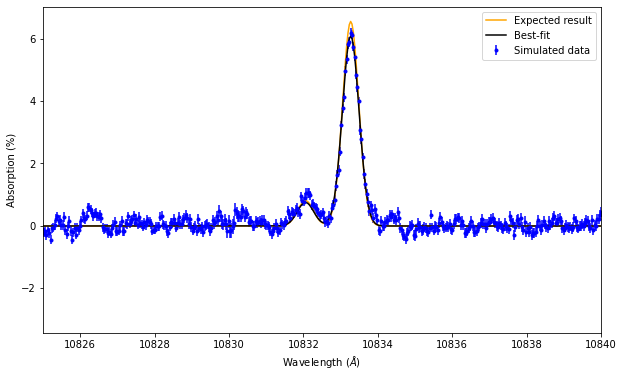

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07872221e+04 -6.04118021e+14 -2.11668136e-03]


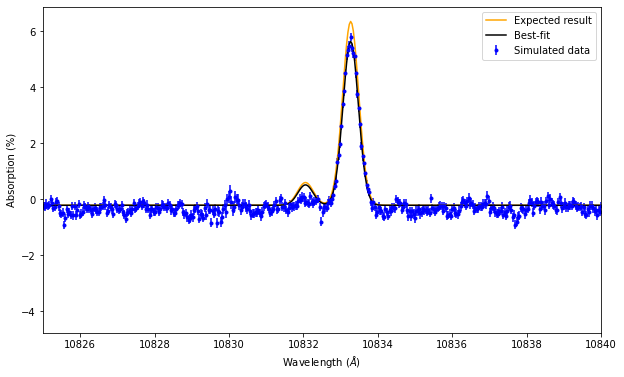

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.19513876e+04 -6.33825791e+14 -2.49112253e-03]


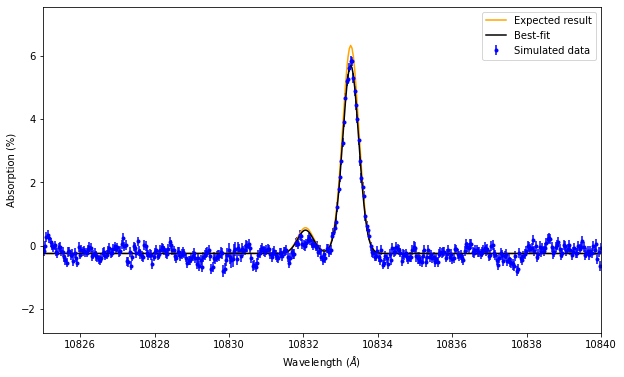

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09650935e+04 -6.18878154e+14 -1.71810972e-03]


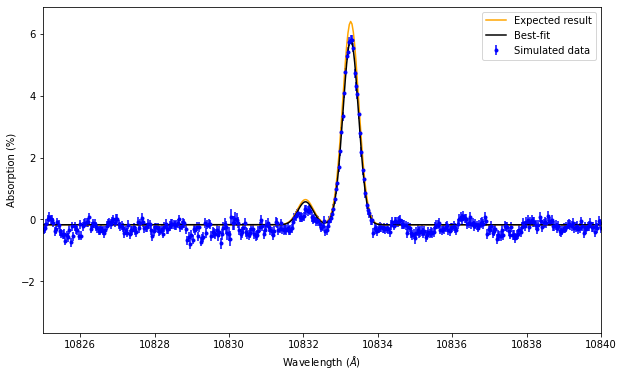

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11778780e+04 -6.26196680e+14 -1.61450659e-04]


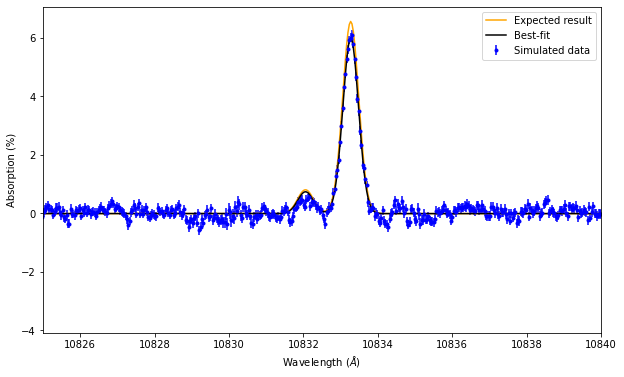

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20901503e+04 -6.48521714e+14  4.90112444e-04]


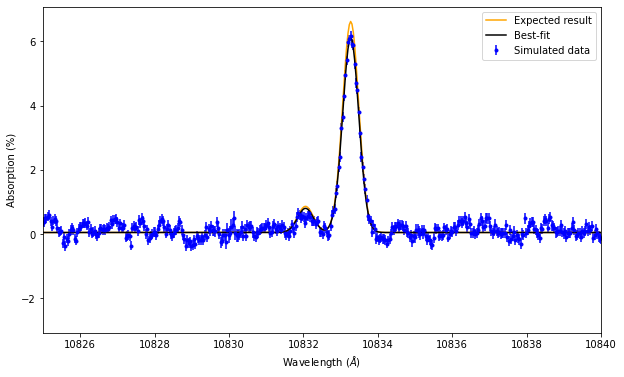

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14522194e+04 -6.25138859e+14 -1.40145685e-03]


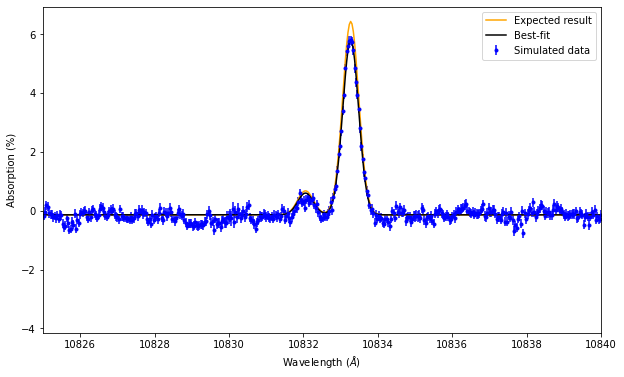

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17732233e+04 -6.33281959e+14  7.41504040e-04]


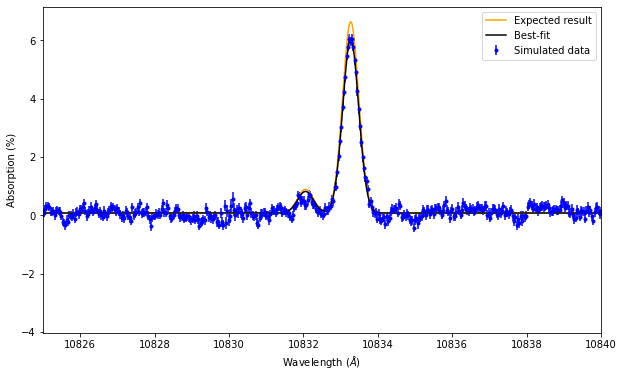

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22812172e+04 -6.50930748e+14 -2.83442750e-04]


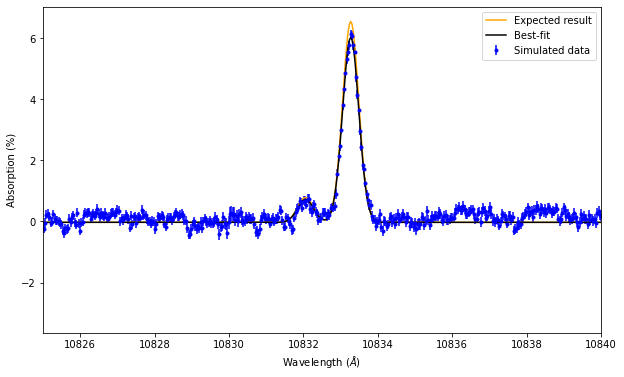

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07143444e+04 -6.05187370e+14  7.65890722e-04]


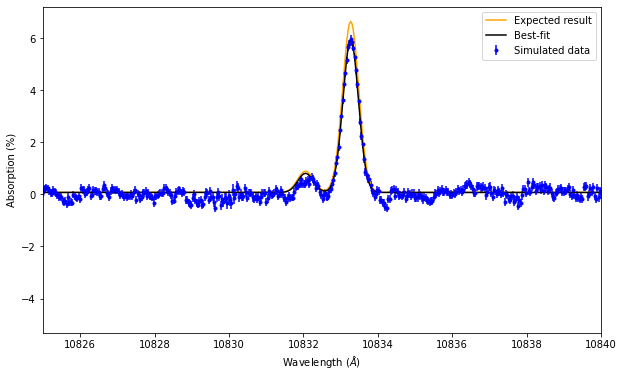

[ 1.39197897e+04 -6.80308265e+14  2.13957559e-03]


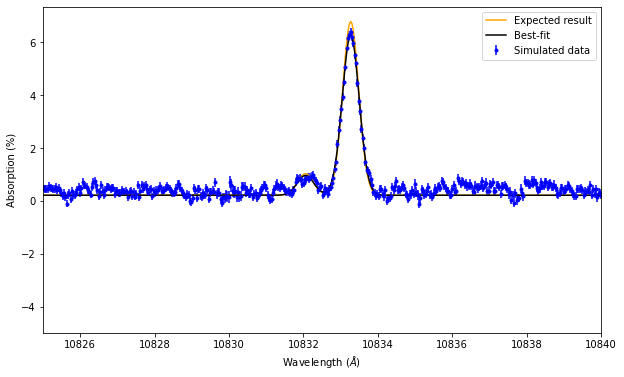

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04427414e+04 -5.90535423e+14 -6.06572212e-04]


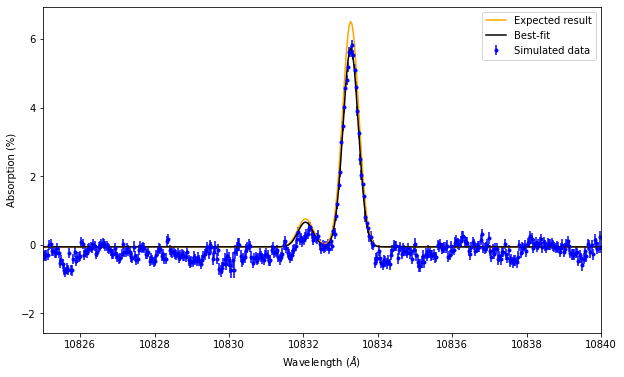

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15449688e+04 -6.15925250e+14 -3.66517754e-05]


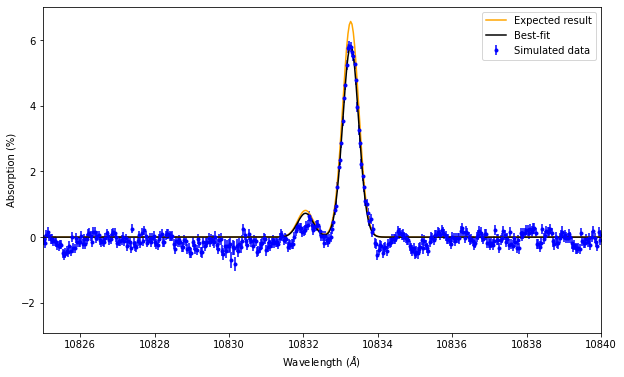

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17913466e+04 -6.45920206e+14  1.10664743e-04]


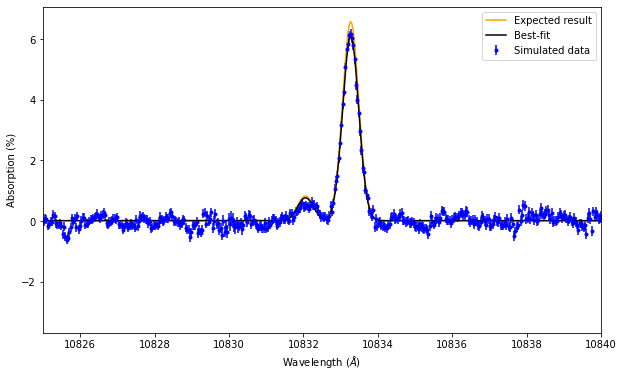

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.30670080e+04 -6.66982259e+14  1.24552354e-03]


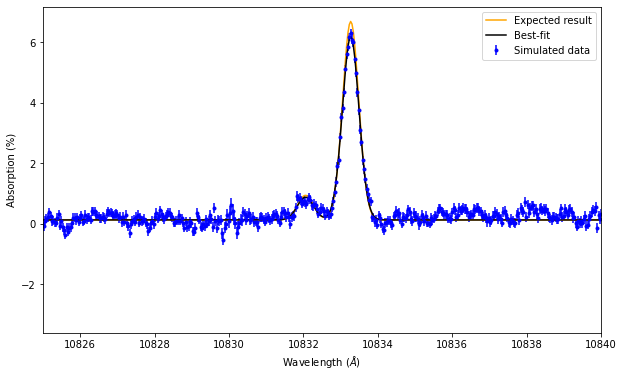

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.26048067e+04 -6.40726957e+14 -2.06922784e-03]


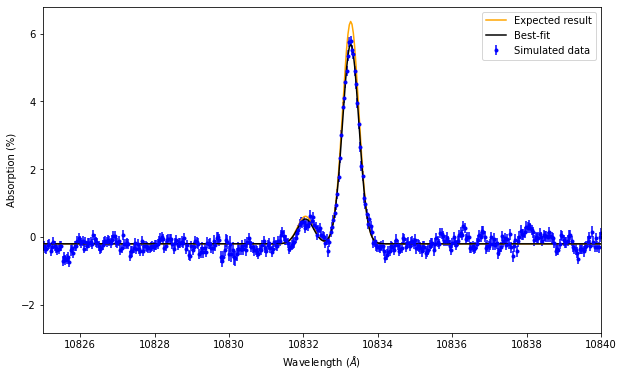

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.26554490e+04 -6.61474202e+14 -4.22326093e-04]


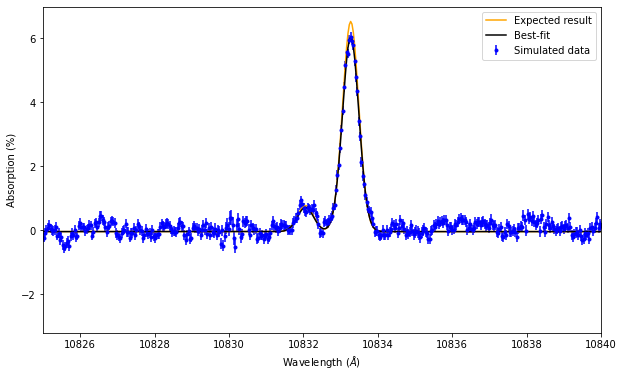

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17066552e+04 -6.33983853e+14  7.49575024e-05]


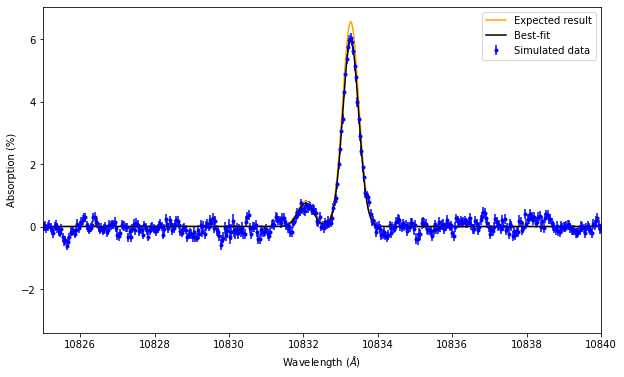

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18749583e+04 -6.46933338e+14  6.54396235e-04]


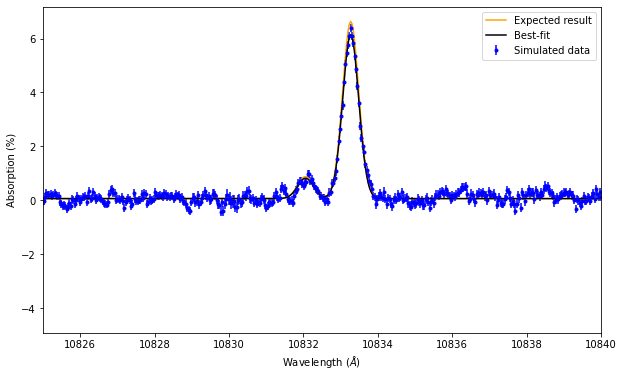

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08546494e+04 -6.20924367e+14 -4.79476110e-04]


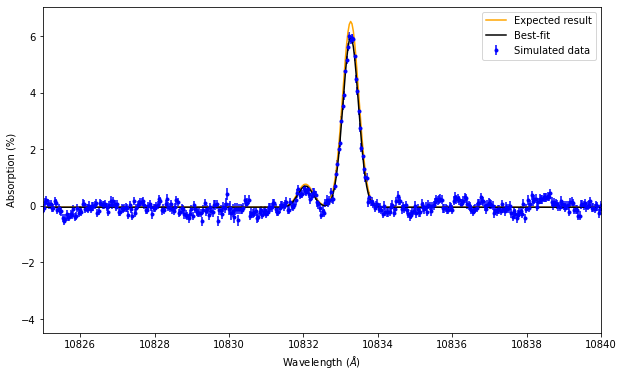

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23304896e+04 -6.41297880e+14 -3.19982259e-04]


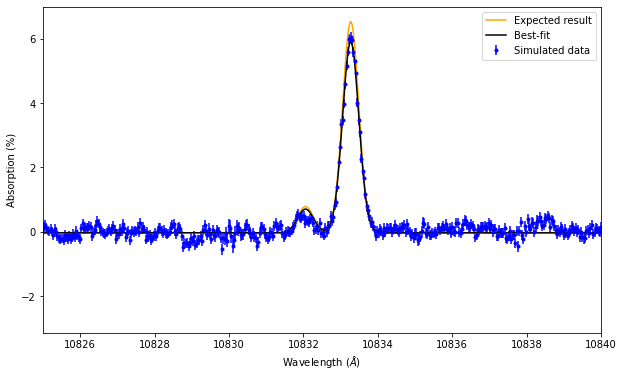

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04129933e+04 -5.98360722e+14 -2.38523833e-03]


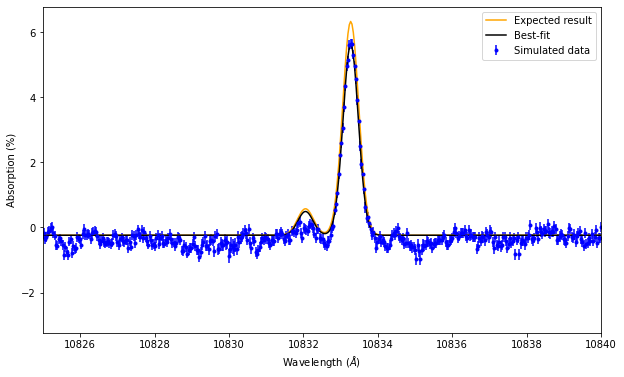

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13007606e+04 -6.22085923e+14 -7.99263745e-04]


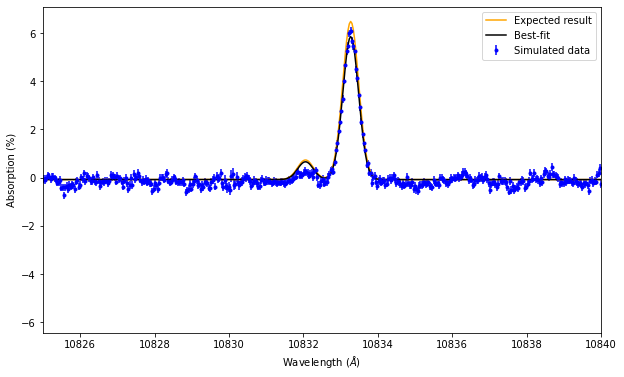

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23760831e+04 -6.49749877e+14 -2.91504614e-04]


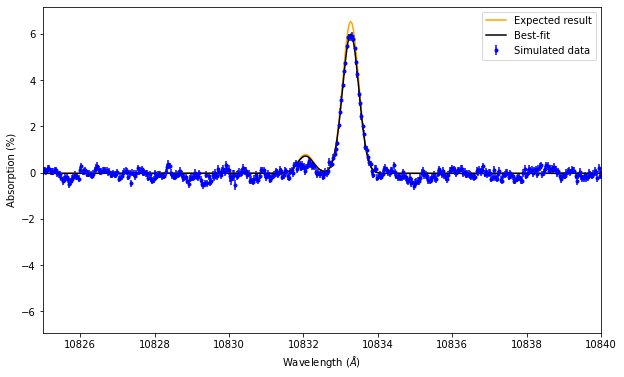

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11949350e+04 -6.21961076e+14  2.40016171e-04]


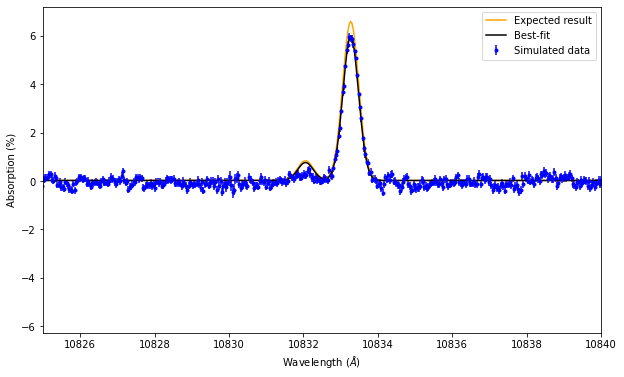

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.21747832e+04 -6.54466029e+14  2.25338646e-03]


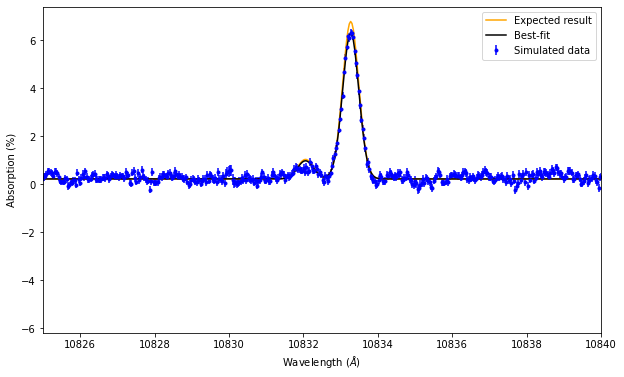

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13582898e+04 -6.31765423e+14 -1.77214509e-05]


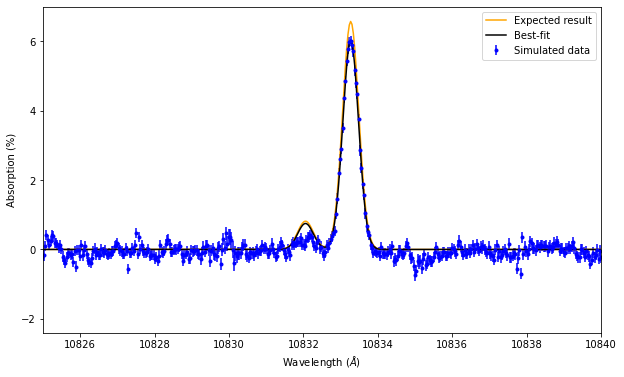

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.24412635e+04 -6.61397914e+14  3.98152308e-03]


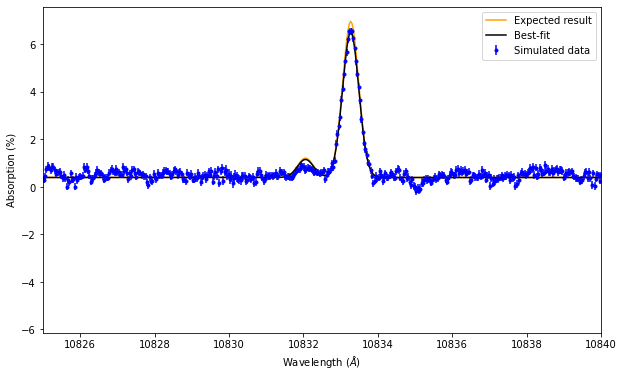

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17174379e+04 -6.37579253e+14 -1.17010643e-03]


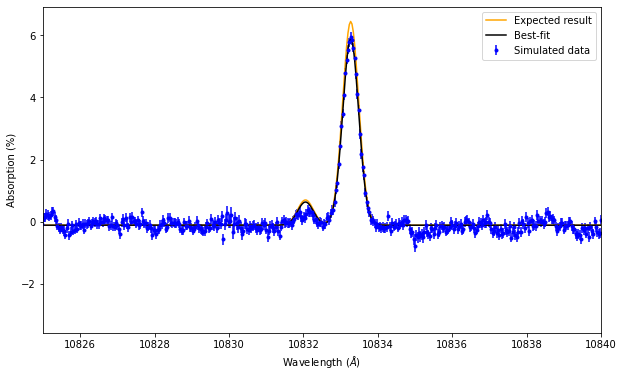

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.31416230e+04 -6.62499062e+14  3.33007871e-03]


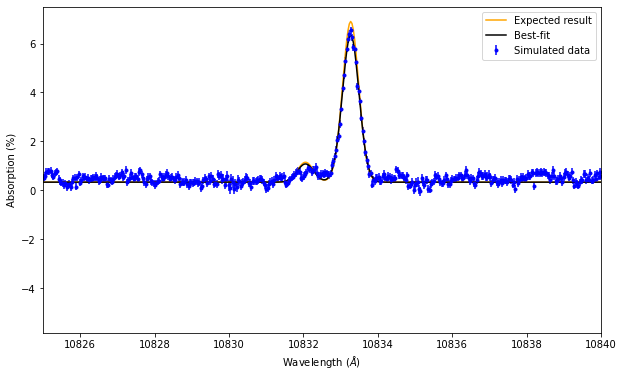

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.28679290e+04 -6.46894014e+14 -1.27172719e-03]


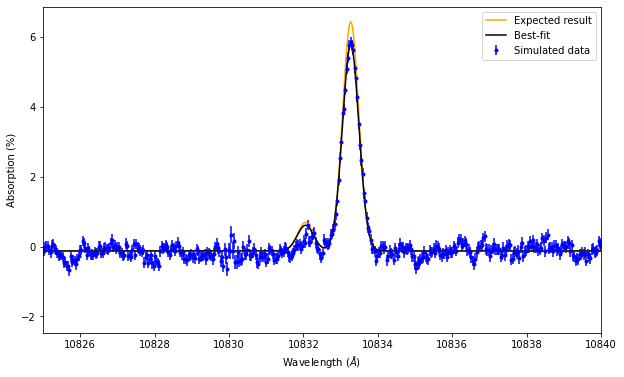

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.35415018e+04 -6.83045816e+14  1.72879322e-03]


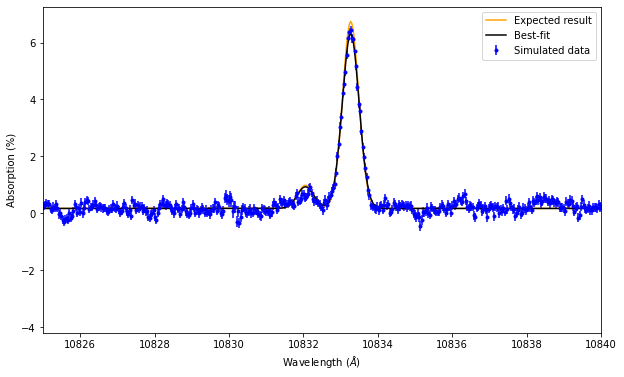

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18802638e+04 -6.46855448e+14 -1.71425764e-03]


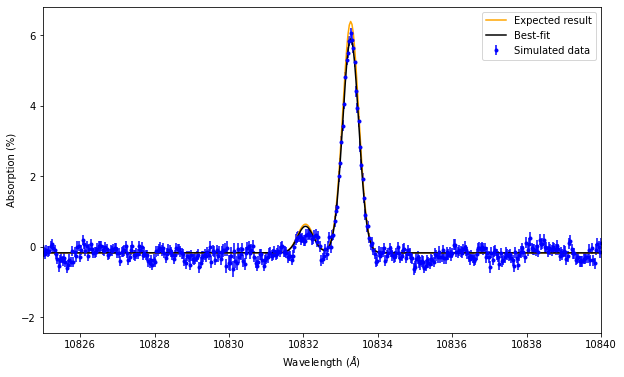

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.26323633e+04 -6.56590623e+14 -5.16868346e-04]


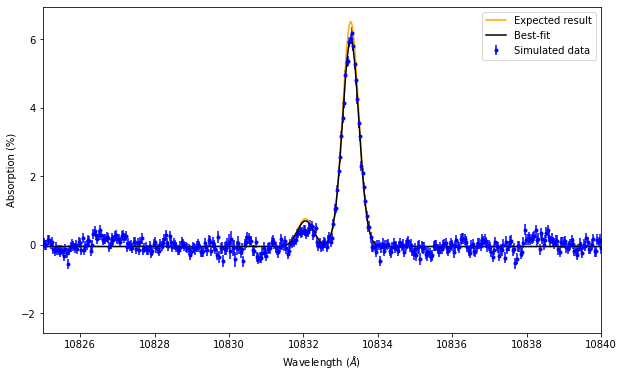

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18647950e+04 -6.27607920e+14  1.76250057e-03]


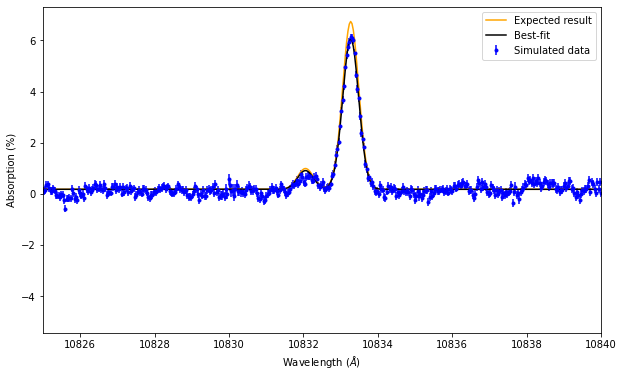

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15803416e+04 -6.19151734e+14  1.00058016e-03]


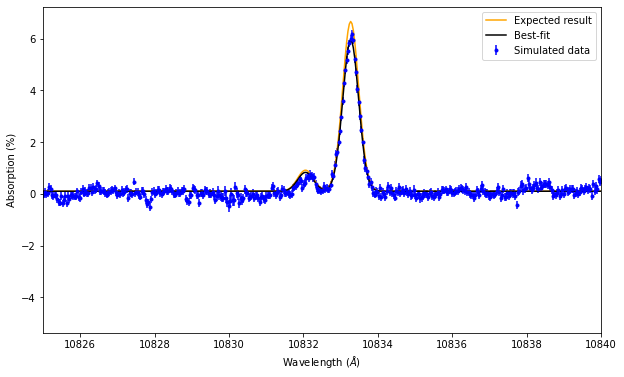

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.24867245e+04 -6.59691629e+14 -8.24587493e-04]


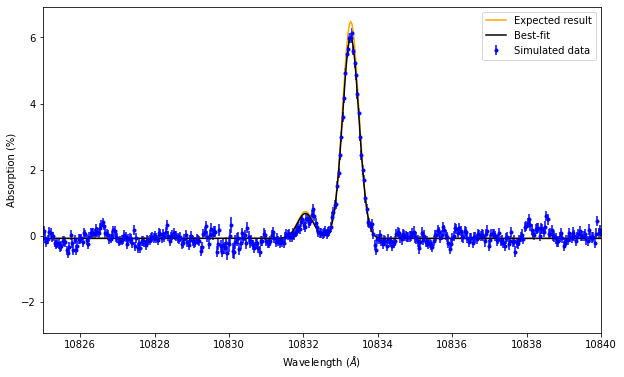

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.23511839e+04 -6.51718328e+14 -5.91719526e-04]


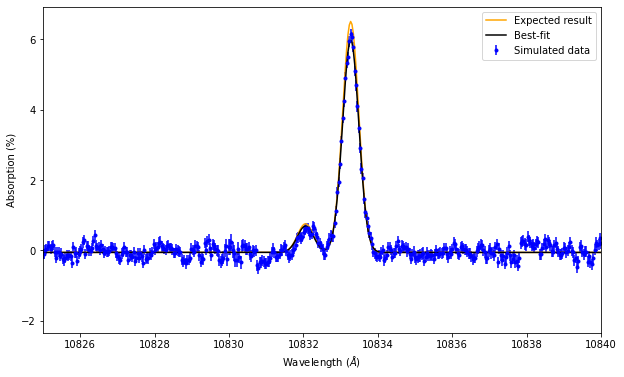

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20802466e+04 -6.35585421e+14  1.01938189e-03]


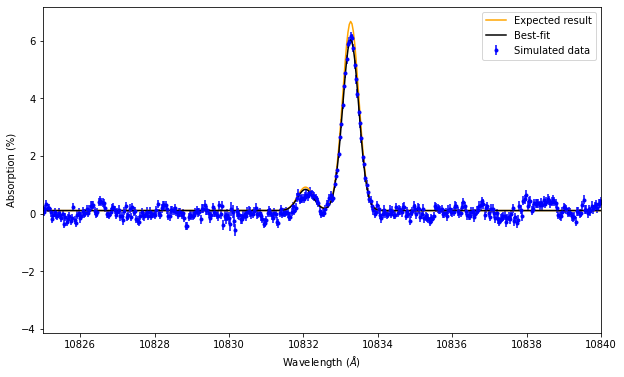

[ 1.41714200e+04 -6.90082871e+14  1.38652485e-03]


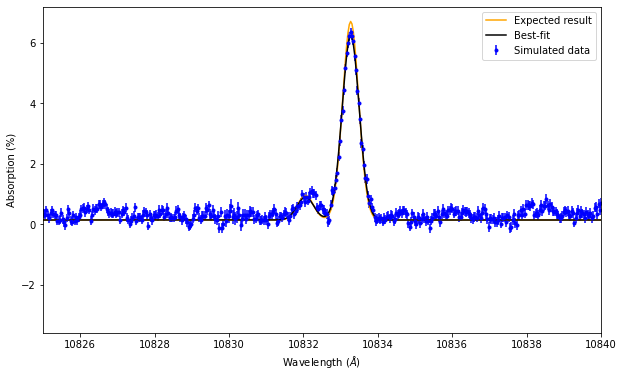

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.29541478e+04 -6.51169070e+14 -1.55563597e-03]


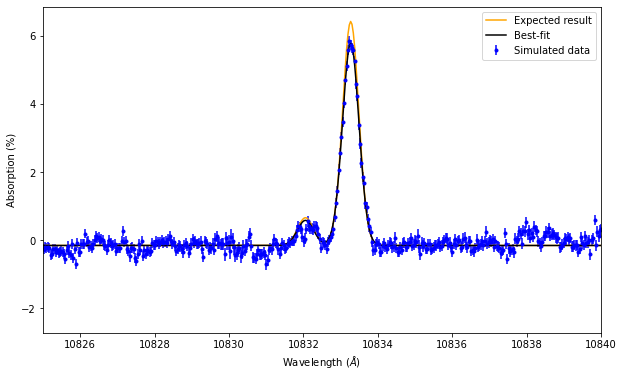

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15826053e+04 -6.22020573e+14 -1.63224588e-03]


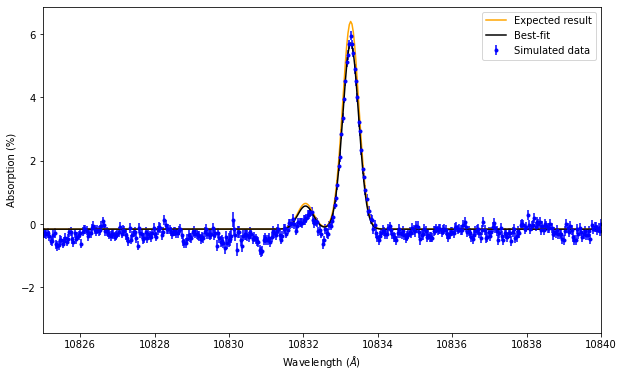

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.25863583e+04 -6.46203264e+14  6.77566817e-04]


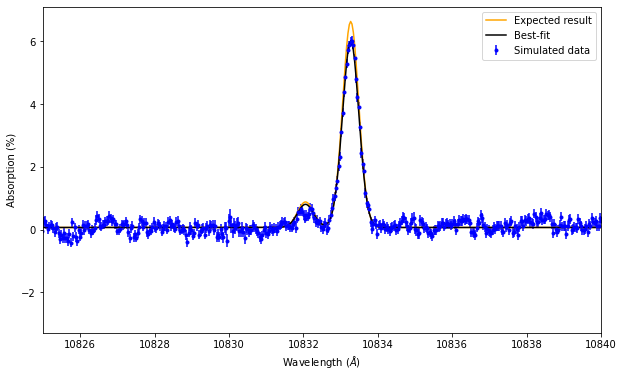

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22312256e+04 -6.45620281e+14 -1.84640616e-03]


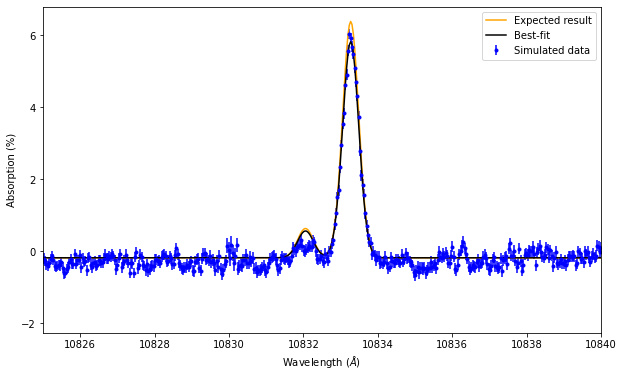

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.29813798e+04 -6.67618147e+14 -1.47813783e-03]


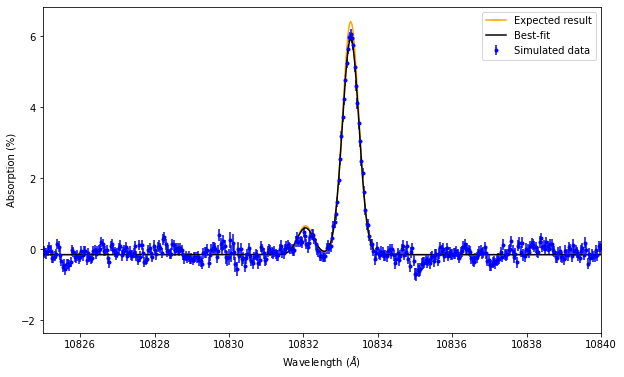

In [64]:
reload(AF)

#Guess on the initial parameters
guess = [16000, 1e14]
guess_HE = [16000, 1e14, 1e-4]

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function_HA(x, temp, density):
        return spec_mod.spectrum_he(x, np.ones(diff_HA[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HA)

    def absorption_function_HE(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HA[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HE)

    #Creating arrays to store the best-fit parameters and the error on them
    param_HA = np.zeros((len(diff_HA), 2))
    err_HA = np.zeros((len(diff_HA), 2))

    param_HE = np.zeros((len(diff_HE), 3))
    err_HE = np.zeros((len(diff_HE), 3))

    #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff_HA)):

        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HA, ref_wave, diff_HA[i], sigma = diff_HA_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HA[i] = params
        err_HA[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HA(ref_wave, params[0], params[1])
        plt.errorbar(ref_wave, 100*(diff_HA[i]-1), yerr=100*diff_HA_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HA(ref_wave, temperature, -density)-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()
        
    for i in range(len(diff_HE)):

        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HE, ref_wave, diff_HE[i], sigma=diff_HE_err[i], p0=guess_HE)

        #Storing the best-fit parameters and errors
        param_HE[i] = params
        err_HE[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HE(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HE[i]-1), yerr = 100*diff_HE_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HE(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'k', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()

#If there is one mode of observation
else:
    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function(x, temp, density):
        return spec_mod.spectrum_he(x, np.ones(diff[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power)

    #Creating arrays to store the best-fit parameters and the error on them
    param = np.zeros((len(diff), 2))
    err = np.zeros((len(diff), 2))
    
   #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff)):

        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function, ref_wave, diff[i], sigma=diff_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param[i] = params
        err[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function(ref_wave, params[0], params[1])
        plt.errorbar(ref_wave, diff[i], diff_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, absorption_function(ref_wave, temperature, -density), color='orange', label='Expected result')
        plt.plot(ref_wave, model, 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()


#For fitting purposes, we needed to have negative densities, so we revert to positive values.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    param_HA[:, 1] = -param_HA[:, 1]
    param_HE[:, 1] = -param_HE[:, 1]
#For fitting purposes, we needed to have negative densities, so we revert to positive values.
else:    
    param[:, 1] = -param[:, 1]



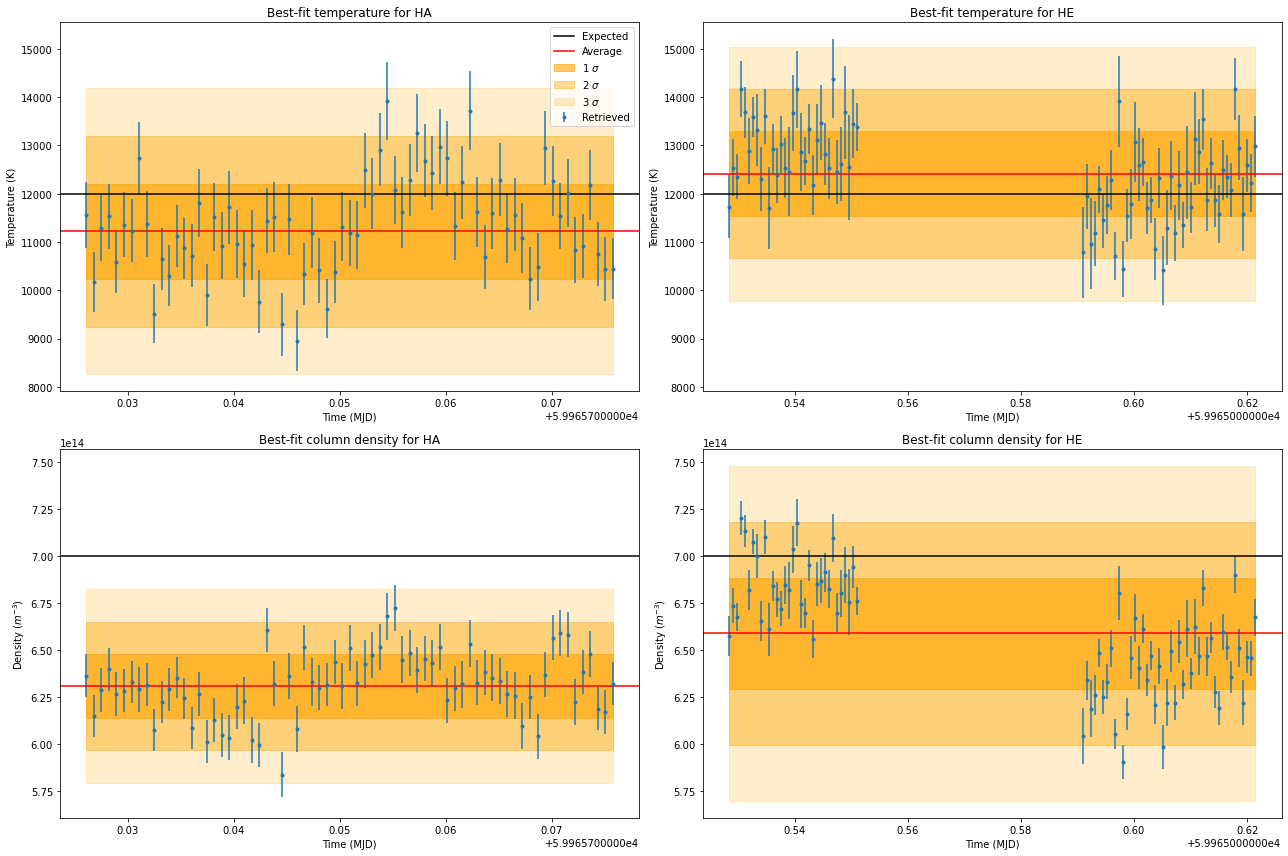

In [65]:
reload(AF)

#Defining a variable to save or not the results.
save = False

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[18, 12])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HA = np.average(param_HA[:, 0], weights=1/err_HA[:, 0]**2)
    weighted_std_T_HA = np.sqrt(np.average((param_HA[:, 0] - weighted_avg_T_HA)**2, weights=1/err_HA[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit_HA, param_HA[:, 0], yerr = err_HA[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature for HA')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T_HA, color='r', label='Average')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-weighted_std_T_HA, y2 = weighted_avg_T_HA+weighted_std_T_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-2*weighted_std_T_HA, y2 = weighted_avg_T_HA+2*weighted_std_T_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-3*weighted_std_T_HA, y2 = weighted_avg_T_HA+3*weighted_std_T_HA, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend(framealpha=0.8)
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HE = np.average(param_HE[:, 0], weights=1/err_HE[:, 0]**2)
    weighted_std_T_HE = np.sqrt(np.average((param_HE[:, 0] - weighted_avg_T_HE)**2, weights=1/err_HE[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax2.errorbar(date_in_transit_HE, param_HE[:, 0], yerr = err_HE[:, 0], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Temperature (K)')
    ax2.set_title('Best-fit temperature for HE')
    ax2.axhline(temperature, color='k', label='Expected')
    ax2.axhline(weighted_avg_T_HE, color='r', label='Average')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-weighted_std_T_HE, y2 = weighted_avg_T_HE+weighted_std_T_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-2*weighted_std_T_HE, y2 = weighted_avg_T_HE+2*weighted_std_T_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-3*weighted_std_T_HE, y2 = weighted_avg_T_HE+3*weighted_std_T_HE, alpha=0.2, color='orange', label='3 $\sigma$')
    
    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HA = np.average(param_HA[:, 1], weights=1/err_HA[:, 1]**2)
    weighted_std_rho_HA = np.sqrt(np.average((param_HA[:, 1] - weighted_avg_rho_HA)**2, weights=1/err_HA[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax3.errorbar(date_in_transit_HA, param_HA[:, 1], yerr = err_HA[:, 1], fmt='.', label='Retrieved')
    ax3.set_xlabel('Time (MJD)')
    ax3.set_ylabel('Density ($m^{-3}$)')
    ax3.set_title('Best-fit column density for HA')
    ax3.axhline(density, color='k', label='Expected')
    ax3.axhline(weighted_avg_rho_HA, color='r', label='Average')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-weighted_std_rho_HA, y2 = weighted_avg_rho_HA+weighted_std_rho_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-2*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+2*weighted_std_rho_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-3*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+3*weighted_std_rho_HA, alpha=0.2, color='orange', label='3 $\sigma$')

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HE = np.average(param_HE[:, 1], weights=1/err_HE[:, 1]**2)
    weighted_std_rho_HE = np.sqrt(np.average((param_HE[:, 1] - weighted_avg_rho_HE)**2, weights=1/err_HE[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax4.errorbar(date_in_transit_HE, param_HE[:, 1], yerr = err_HE[:, 1], fmt='.', label='Retrieved ')
    ax4.set_xlabel('Time (MJD)')
    ax4.set_ylabel('Density ($m^{-3}$)')
    ax4.set_title('Best-fit column density for HE')
    ax4.axhline(density, color='k', label='Expected')
    ax4.axhline(weighted_avg_rho_HE, color='r', label='Average')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-weighted_std_rho_HE, y2 = weighted_avg_rho_HE+weighted_std_rho_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-2*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+2*weighted_std_rho_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-3*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+3*weighted_std_rho_HE, alpha=0.2, color='orange', label='3 $\sigma$')

    ax1.sharey(ax2)
    ax3.sharey(ax4)

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')

#If there is one mode of observation
else:
    
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T = np.average(param[:, 0], weights=1/err[:, 0]**2)
    weighted_std_T = np.sqrt(np.average((param[:, 0] - weighted_avg_T)**2, weights=1/err[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit, param[:, 0], yerr = err[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T, color='r', label='Average')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-weighted_std_T, y2 = weighted_avg_T+weighted_std_T, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-2*weighted_std_T, y2 = weighted_avg_T+2*weighted_std_T, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-3*weighted_std_T, y2 = weighted_avg_T+3*weighted_std_T, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend()

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho = np.average(param[:, 1], weights=1/err[:, 1]**2)
    weighted_std_rho = np.sqrt(np.average((param[:, 1] - weighted_avg_rho)**2, weights=1/err[:, 1]**2))
        
    #Plotting the retrieved densities.
    ax2.errorbar(date_in_transit, param[:, 1], yerr = err[:, 1], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Density ($m^{-3}$)')
    ax2.set_title('Best-fit column density')
    ax2.axhline(density, color='k', label='Expected')
    ax2.axhline(weighted_avg_T, color='r', label='Average')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-weighted_std_T, y2 = weighted_avg_rho+weighted_std_rho, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-2*weighted_std_rho, y2 = weighted_avg_rho+2*weighted_std_rho, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-3*weighted_std_rho, y2 = weighted_avg_rho+3*weighted_std_rho, alpha=0.2, color='orange', label='3 $\sigma$')
    ax2.legend()

    ax1.sharey(ax2)
    ax3.sharey(ax4)

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')
   